In [1]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor

from data_processing import *

In [2]:
df = get_data('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


# 5. Exploratory Data Analysis (EDA)

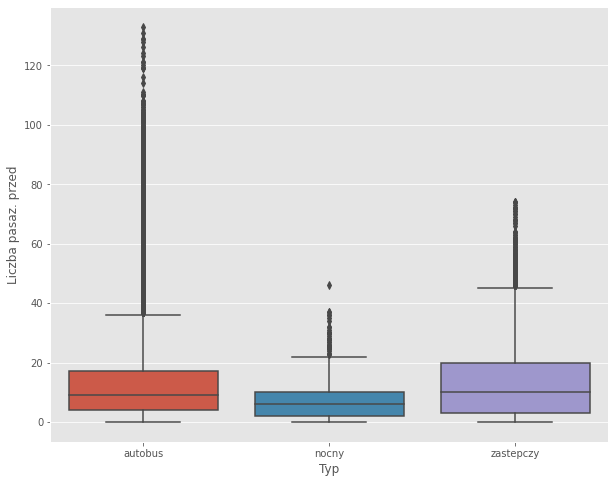

In [3]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    y="Liczba pasaz. przed",
    x='Typ',
    data=df
)

<Figure size 432x288 with 0 Axes>

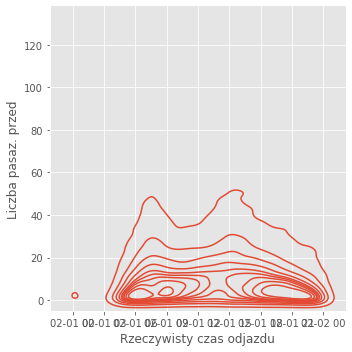

In [4]:
plt.figure()
ax = sns.displot(
    df,
    x='Rzeczywisty czas odjazdu',
    y="Liczba pasaz. przed",
    kind='kde'
)

<Figure size 432x288 with 0 Axes>

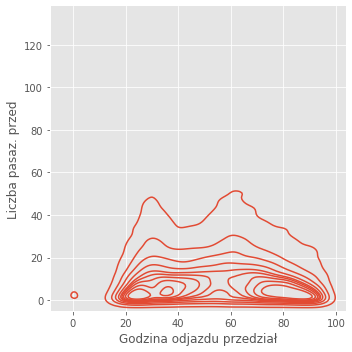

In [5]:
plt.figure()
ax = sns.displot(
    df,
    x='Godzina odjazdu przedział',
    y="Liczba pasaz. przed",
    kind='kde'
)

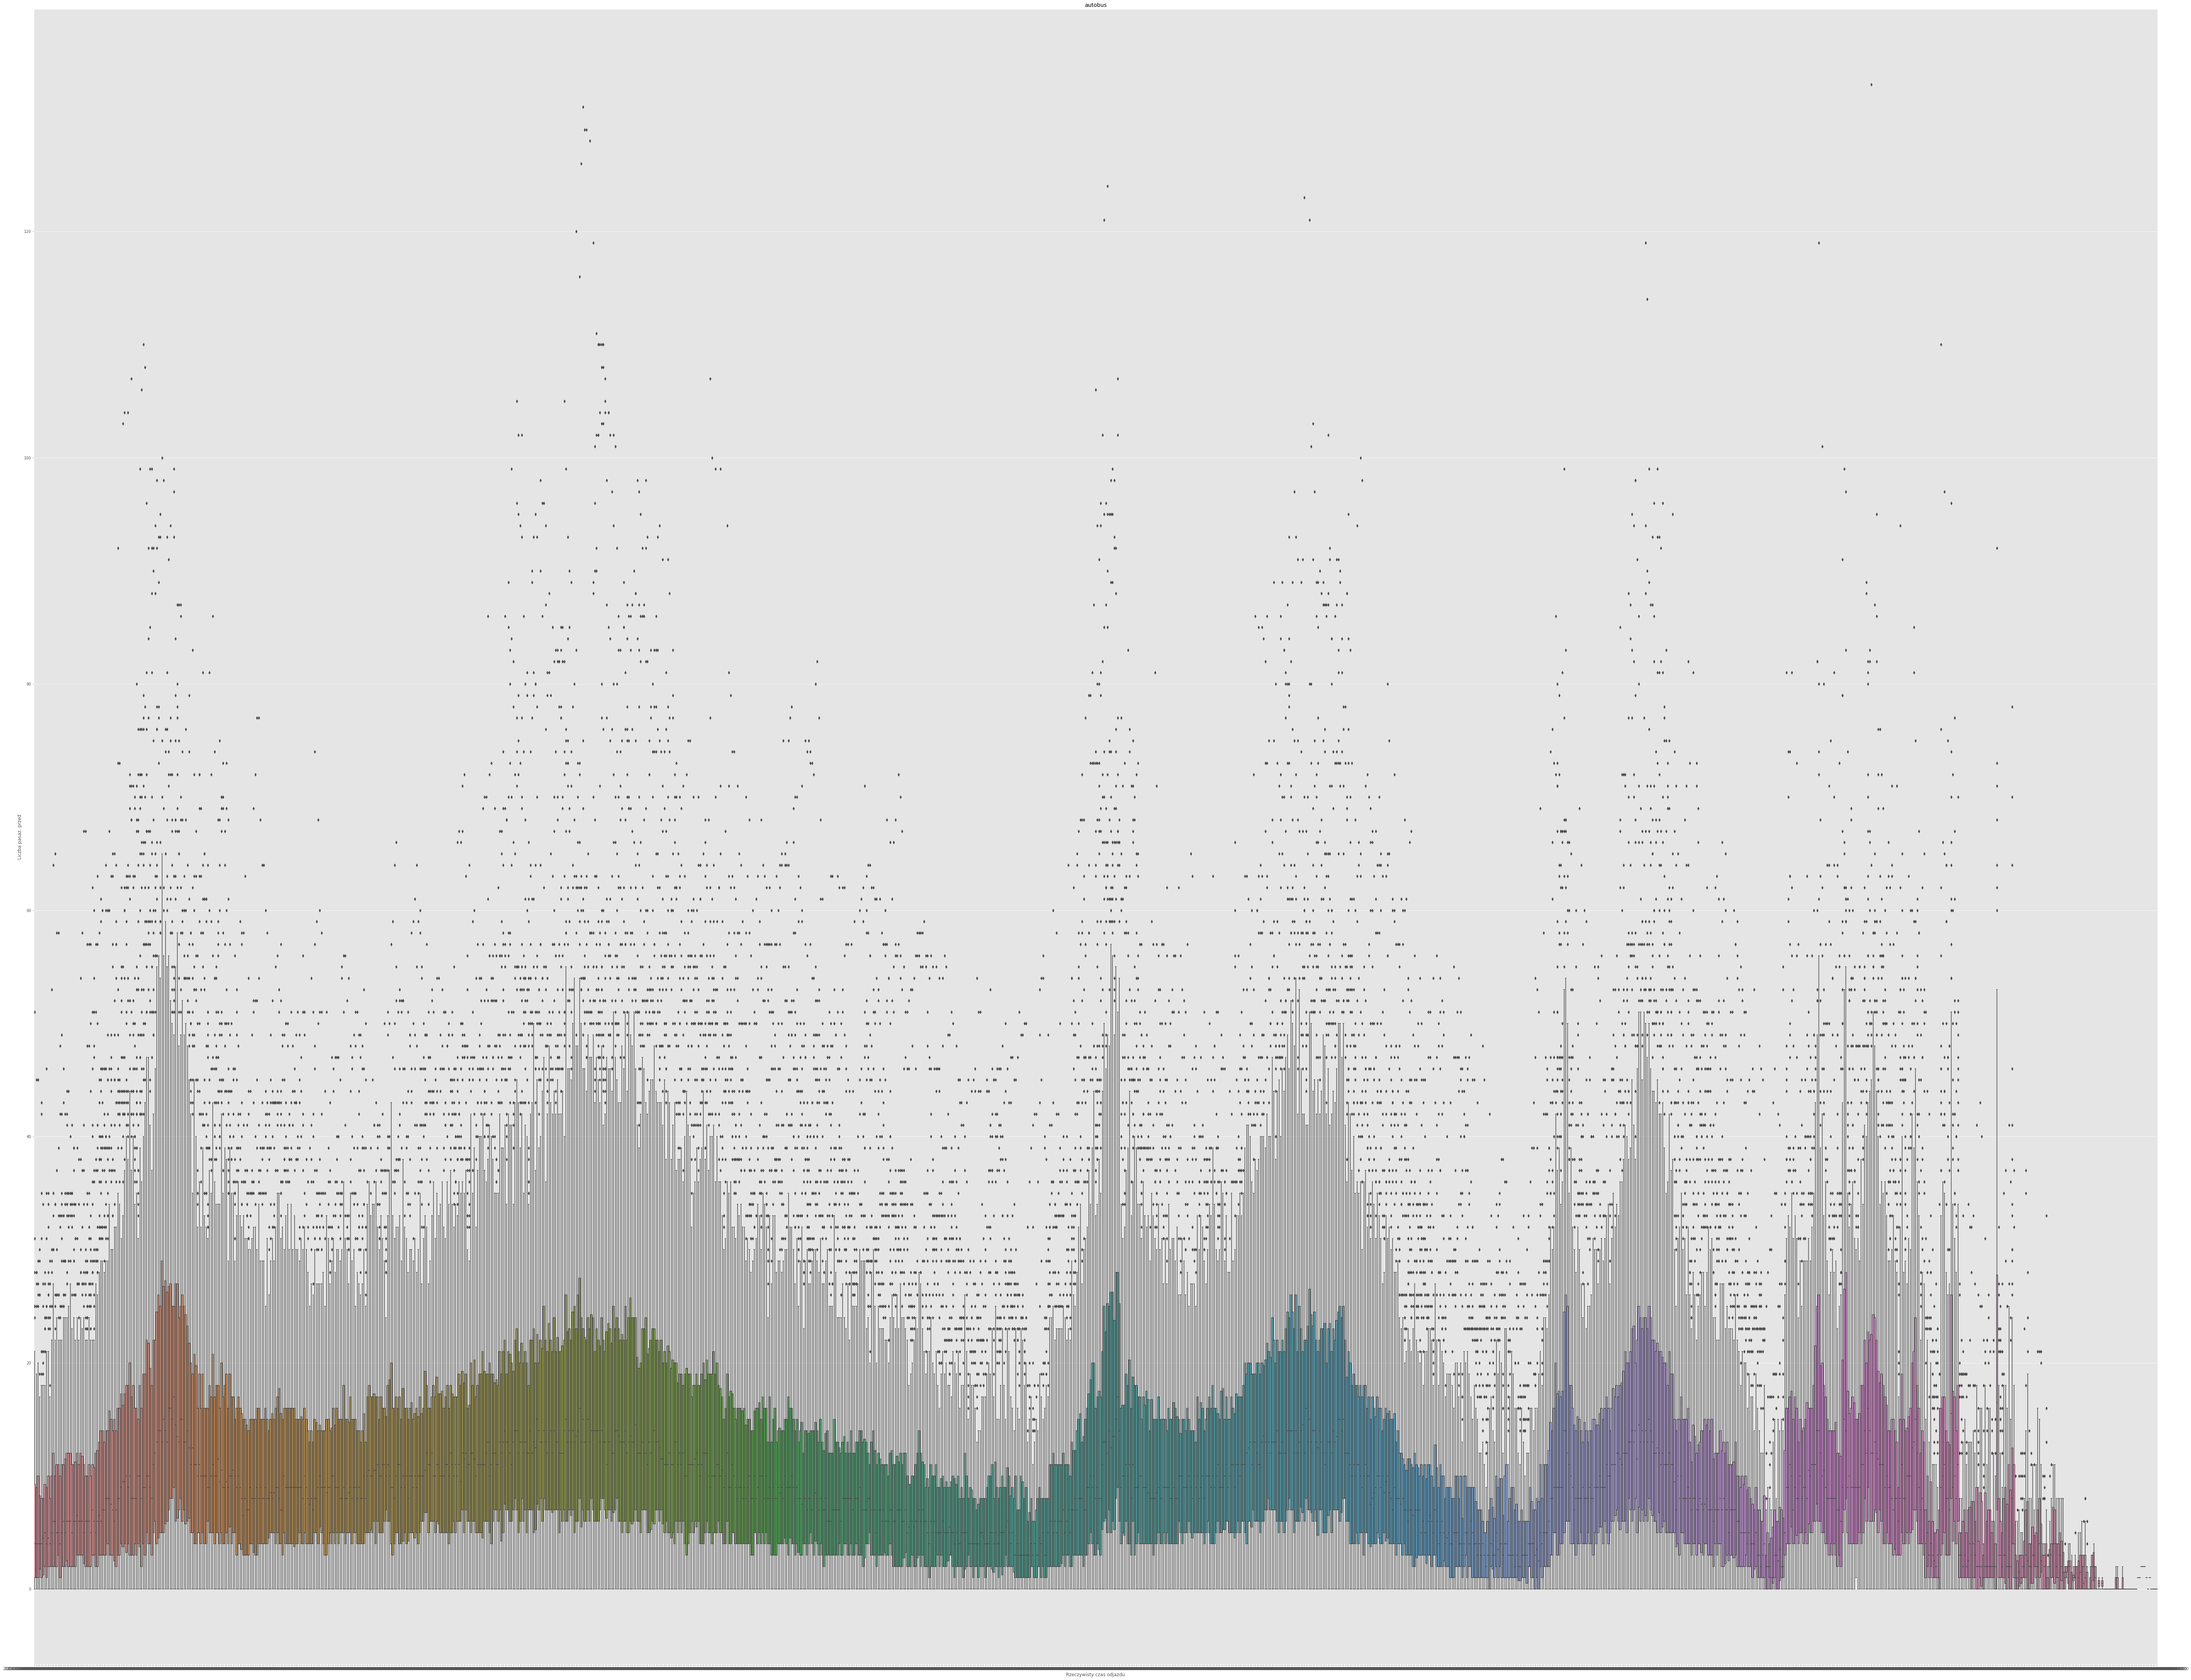

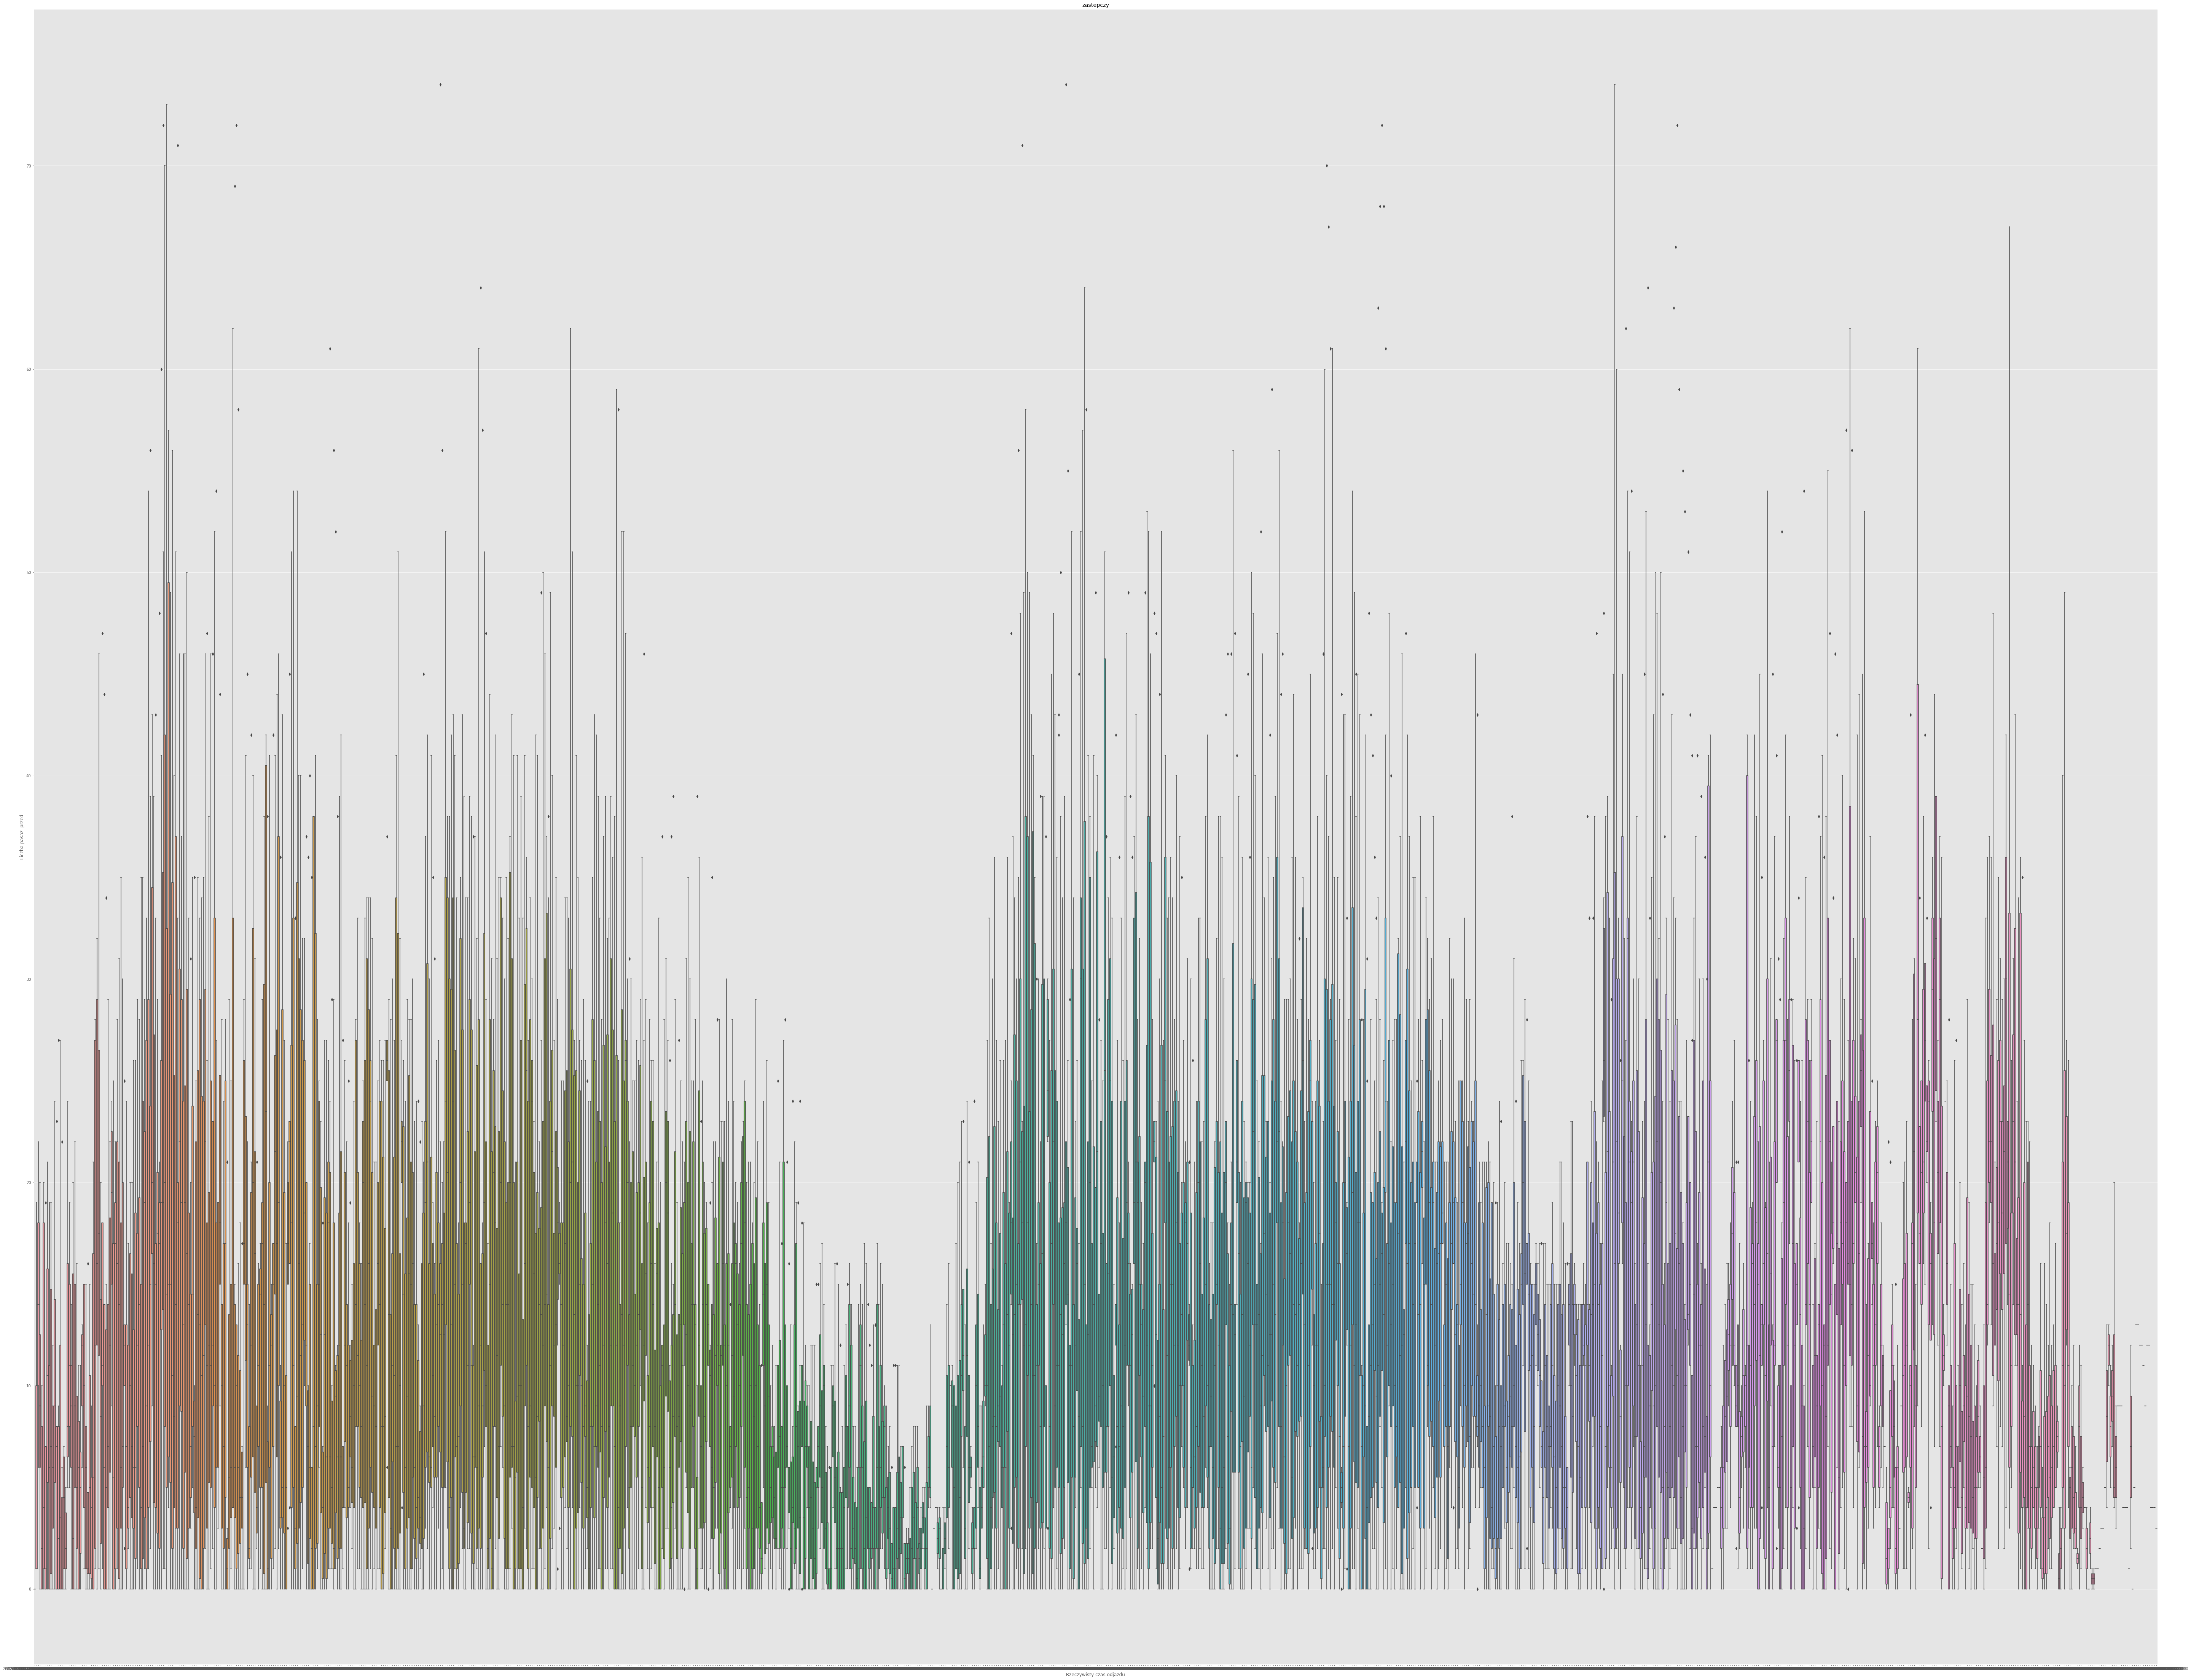

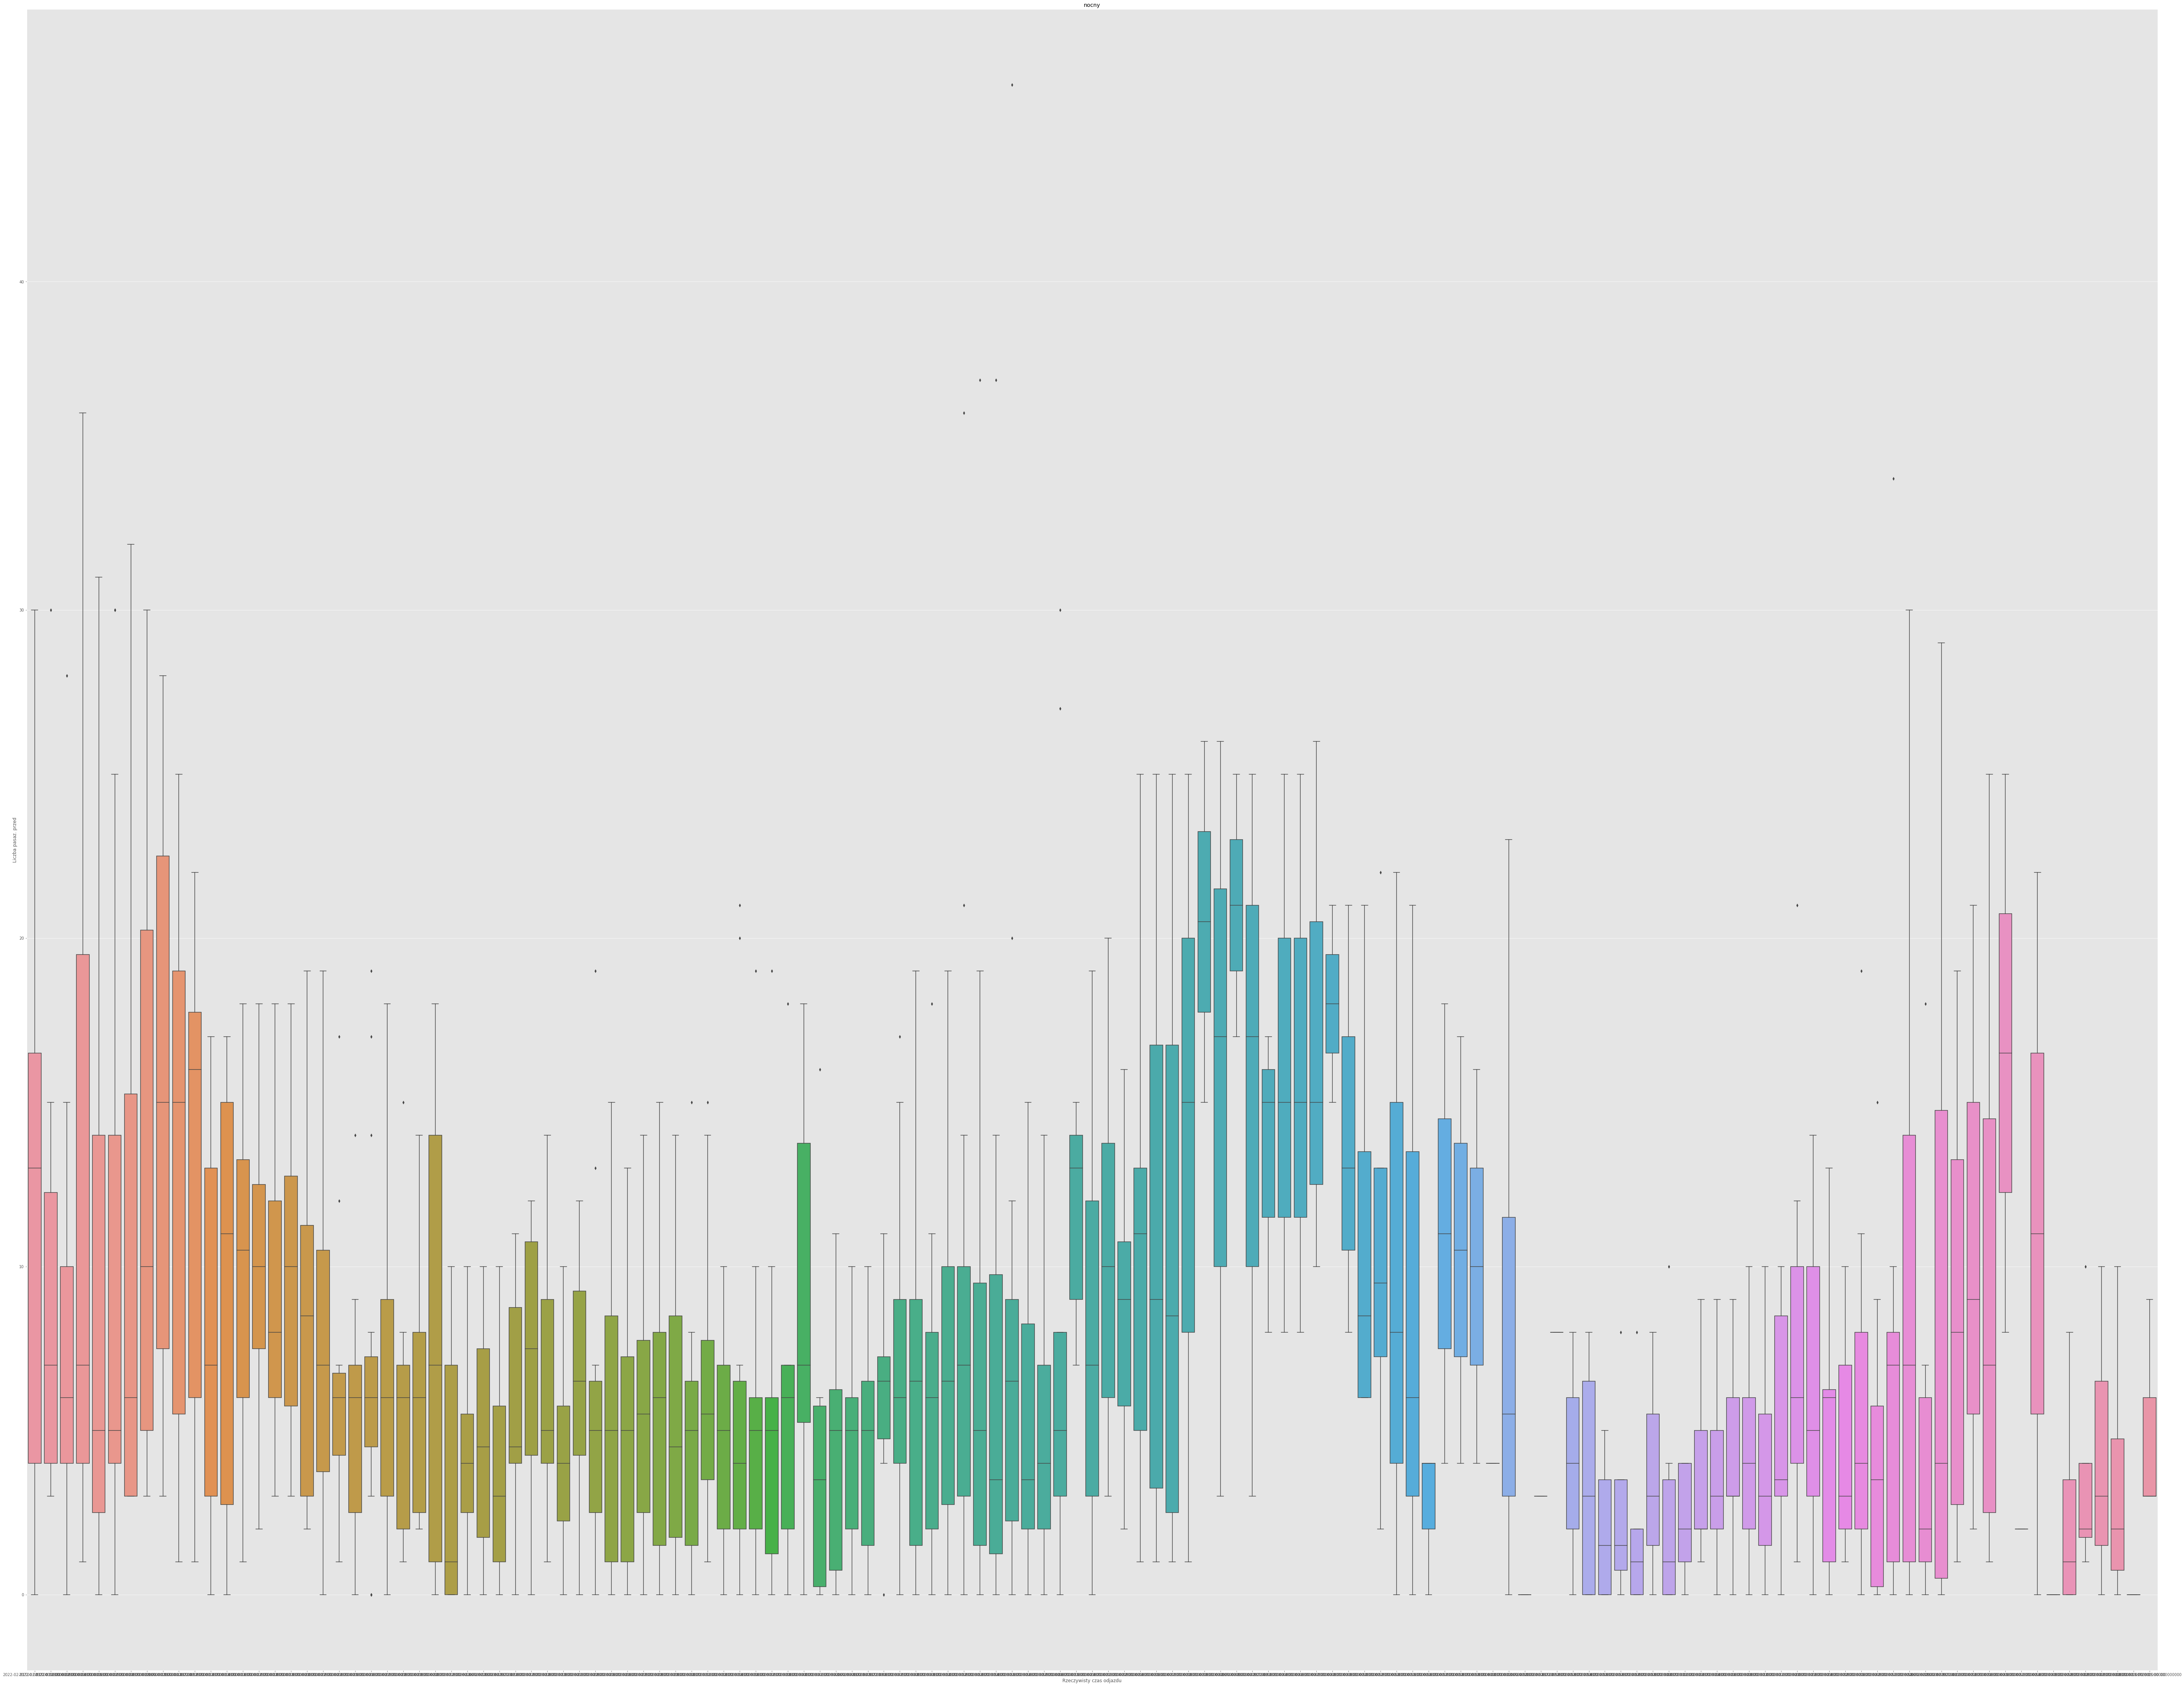

In [6]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Rzeczywisty czas odjazdu',
        y="Liczba pasaz. przed",
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

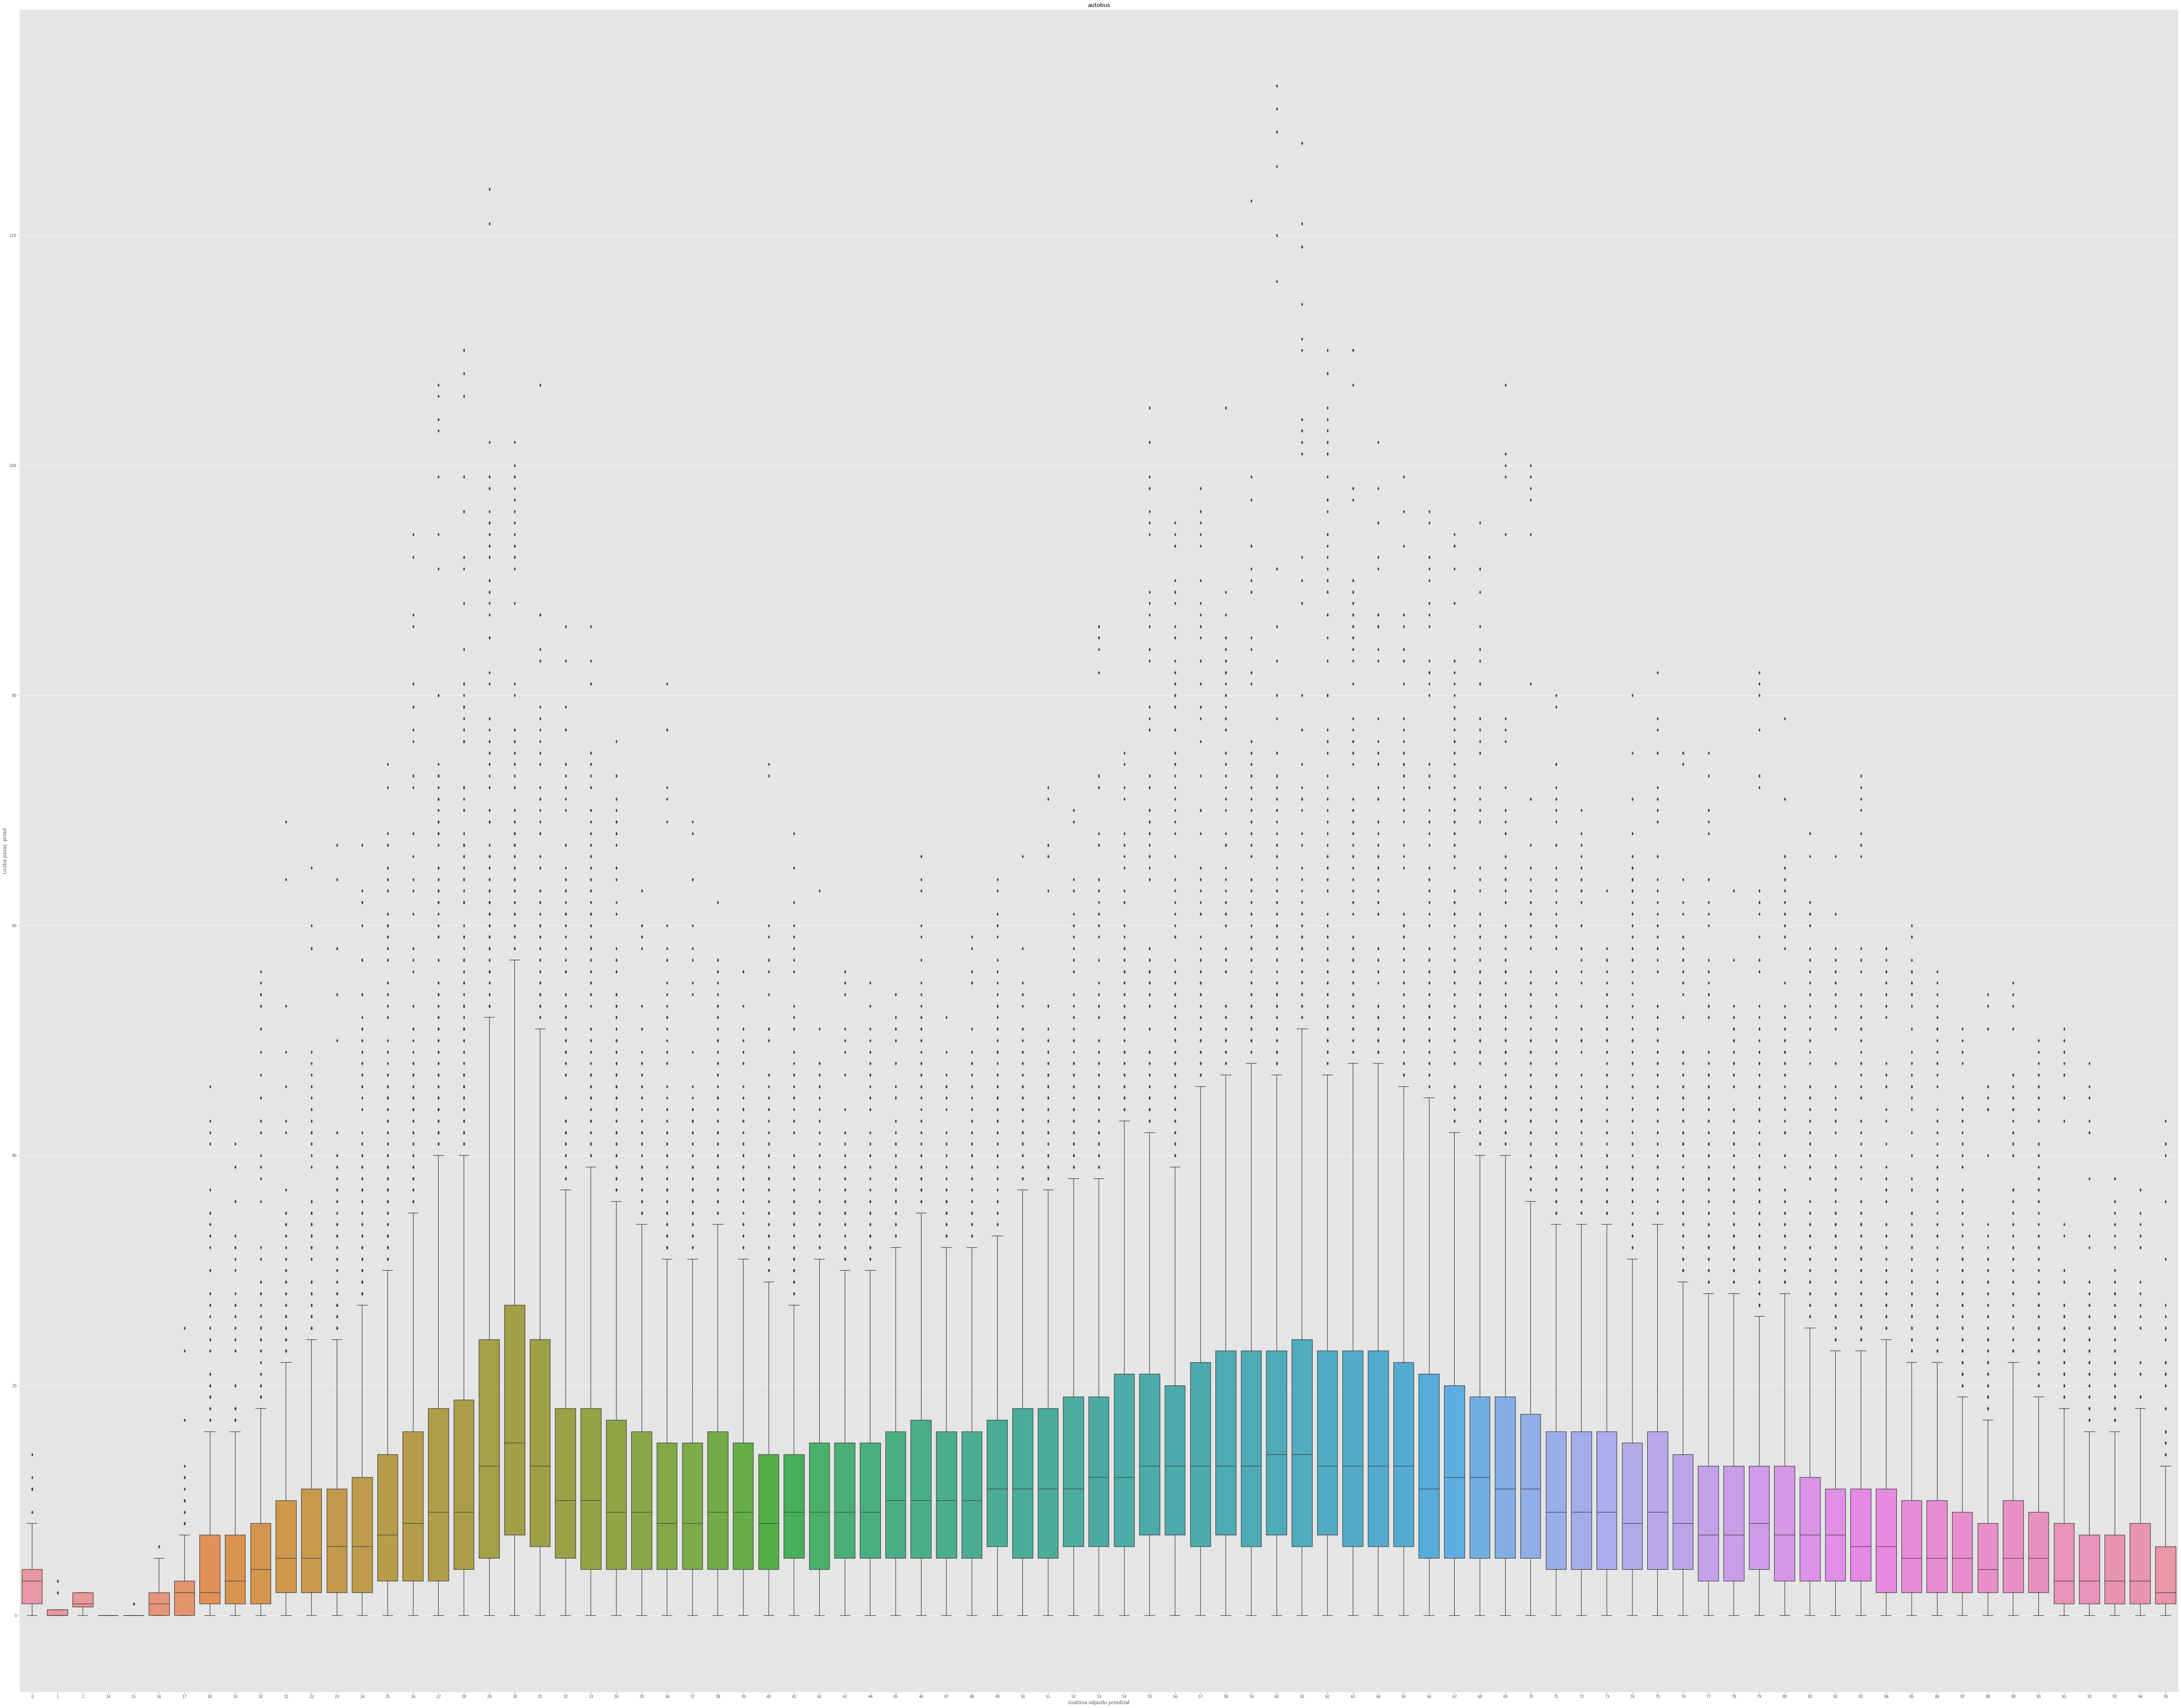

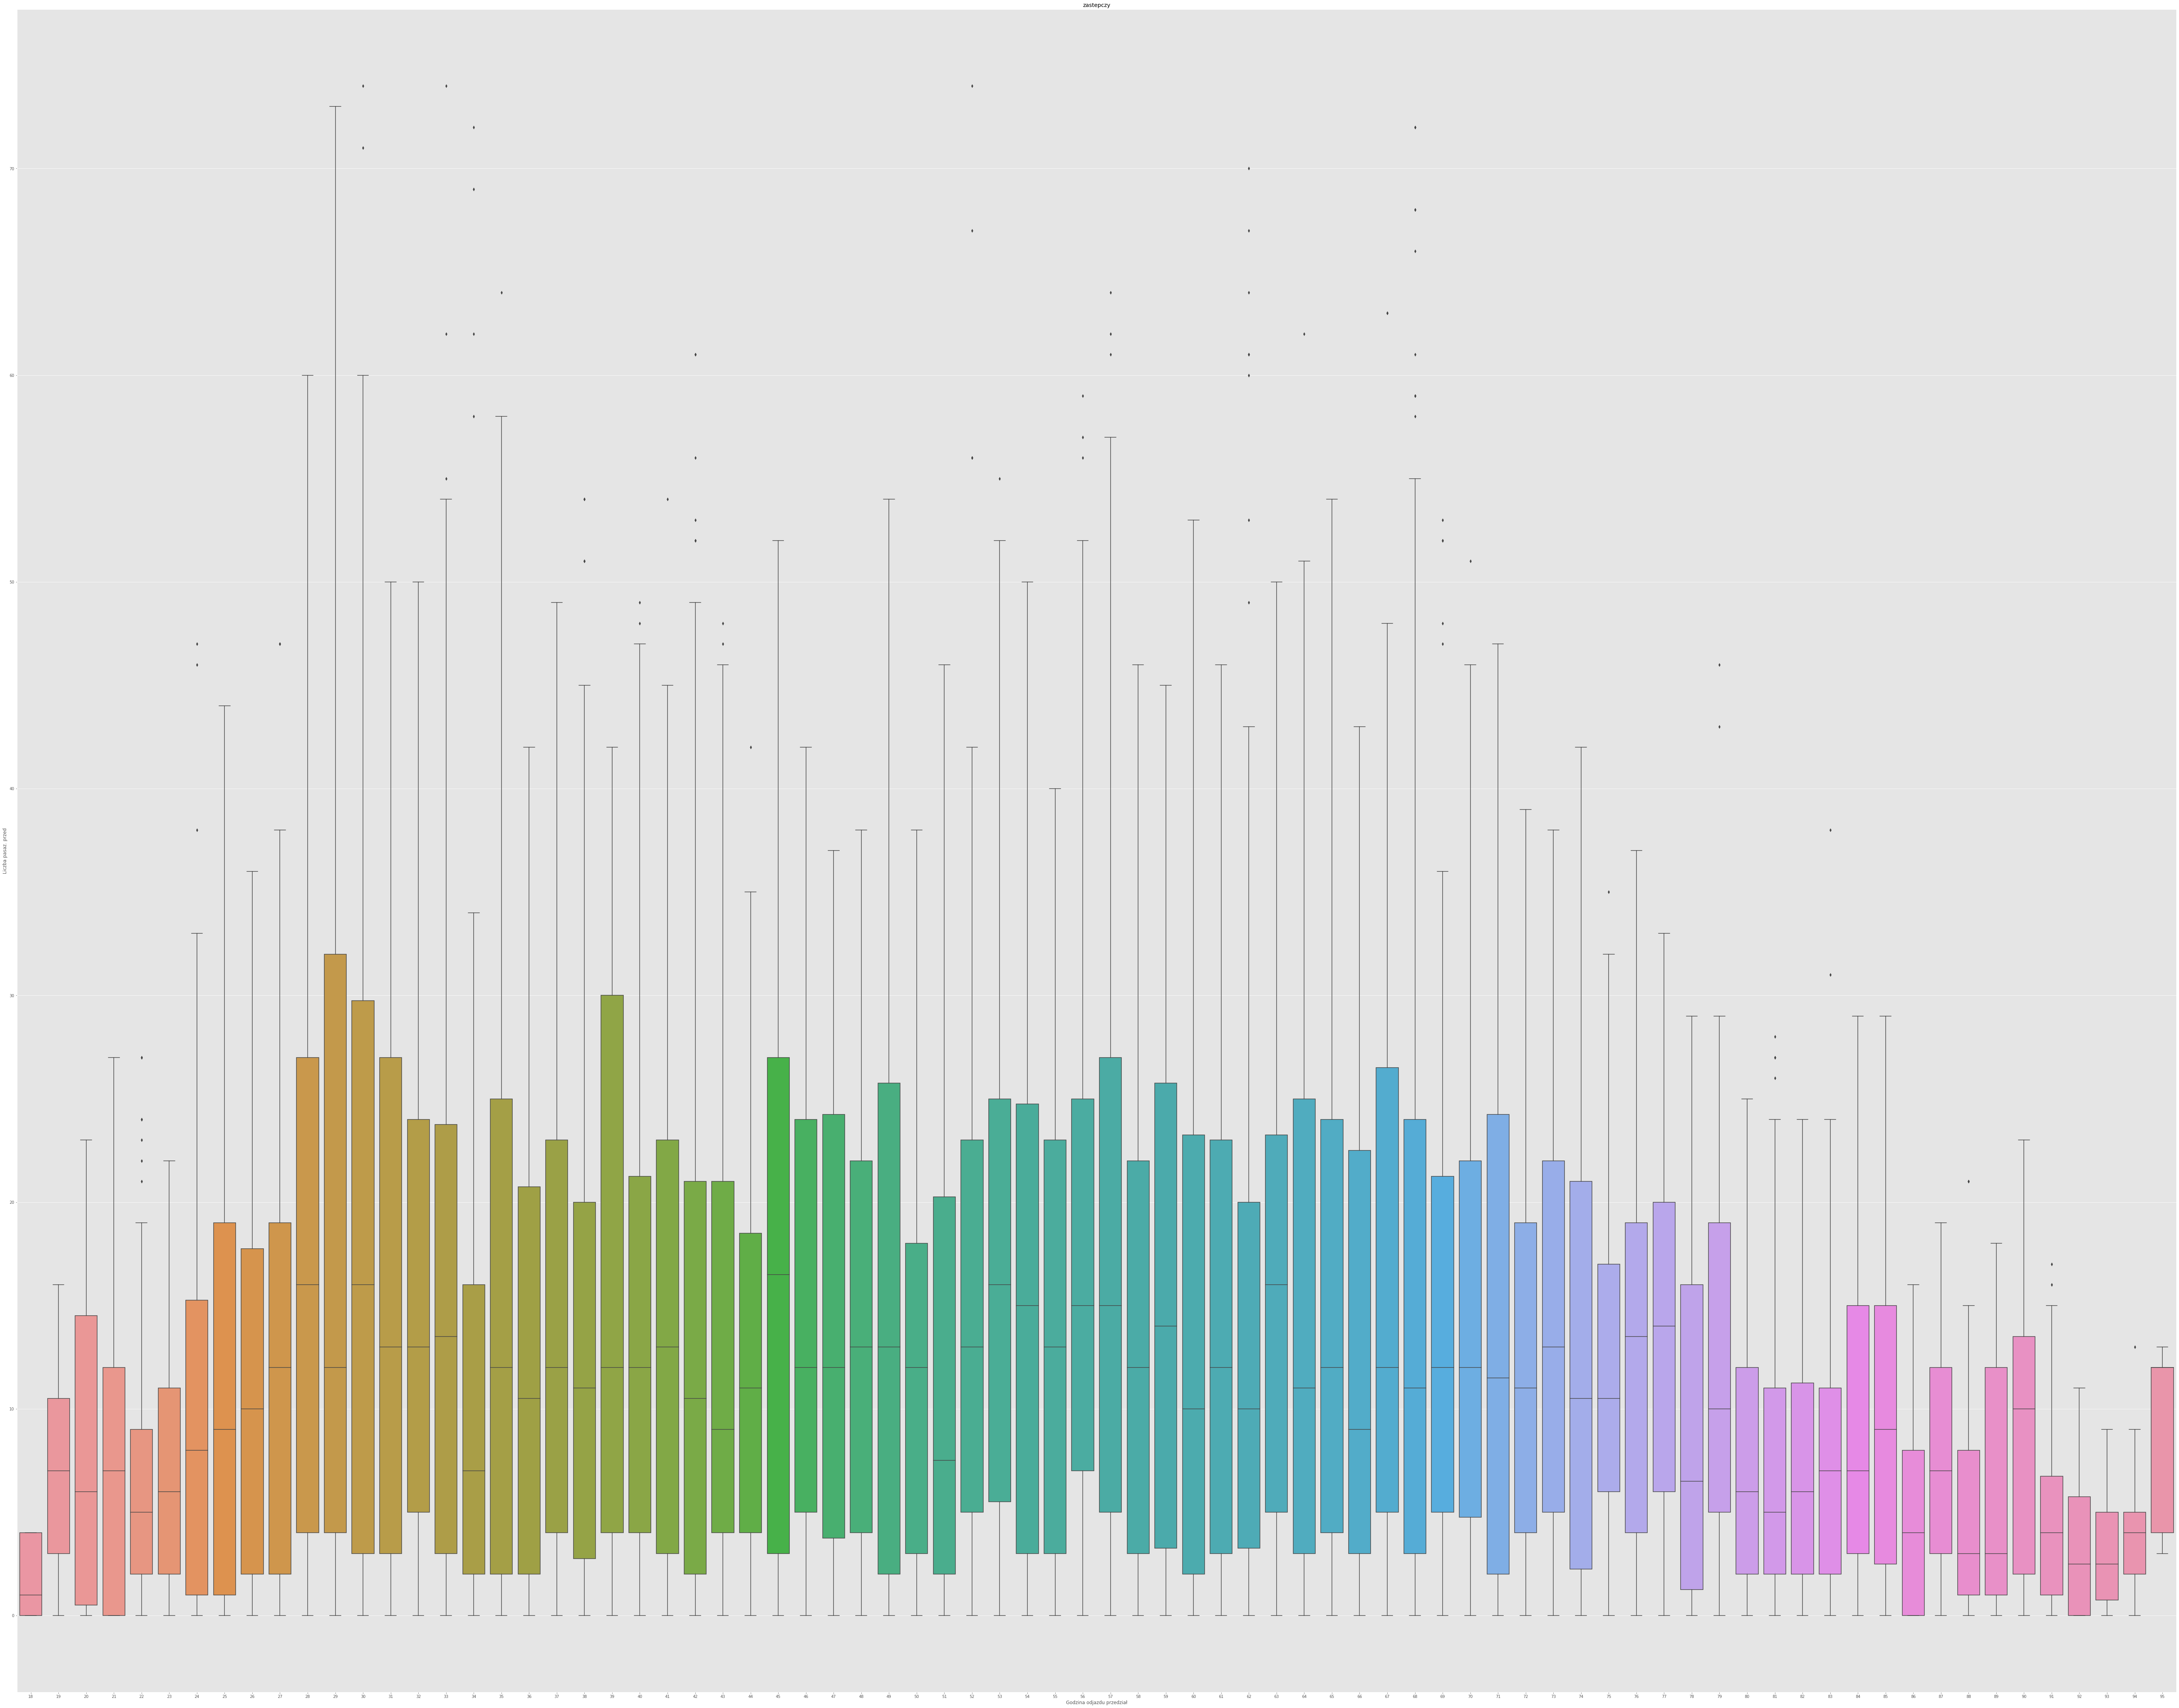

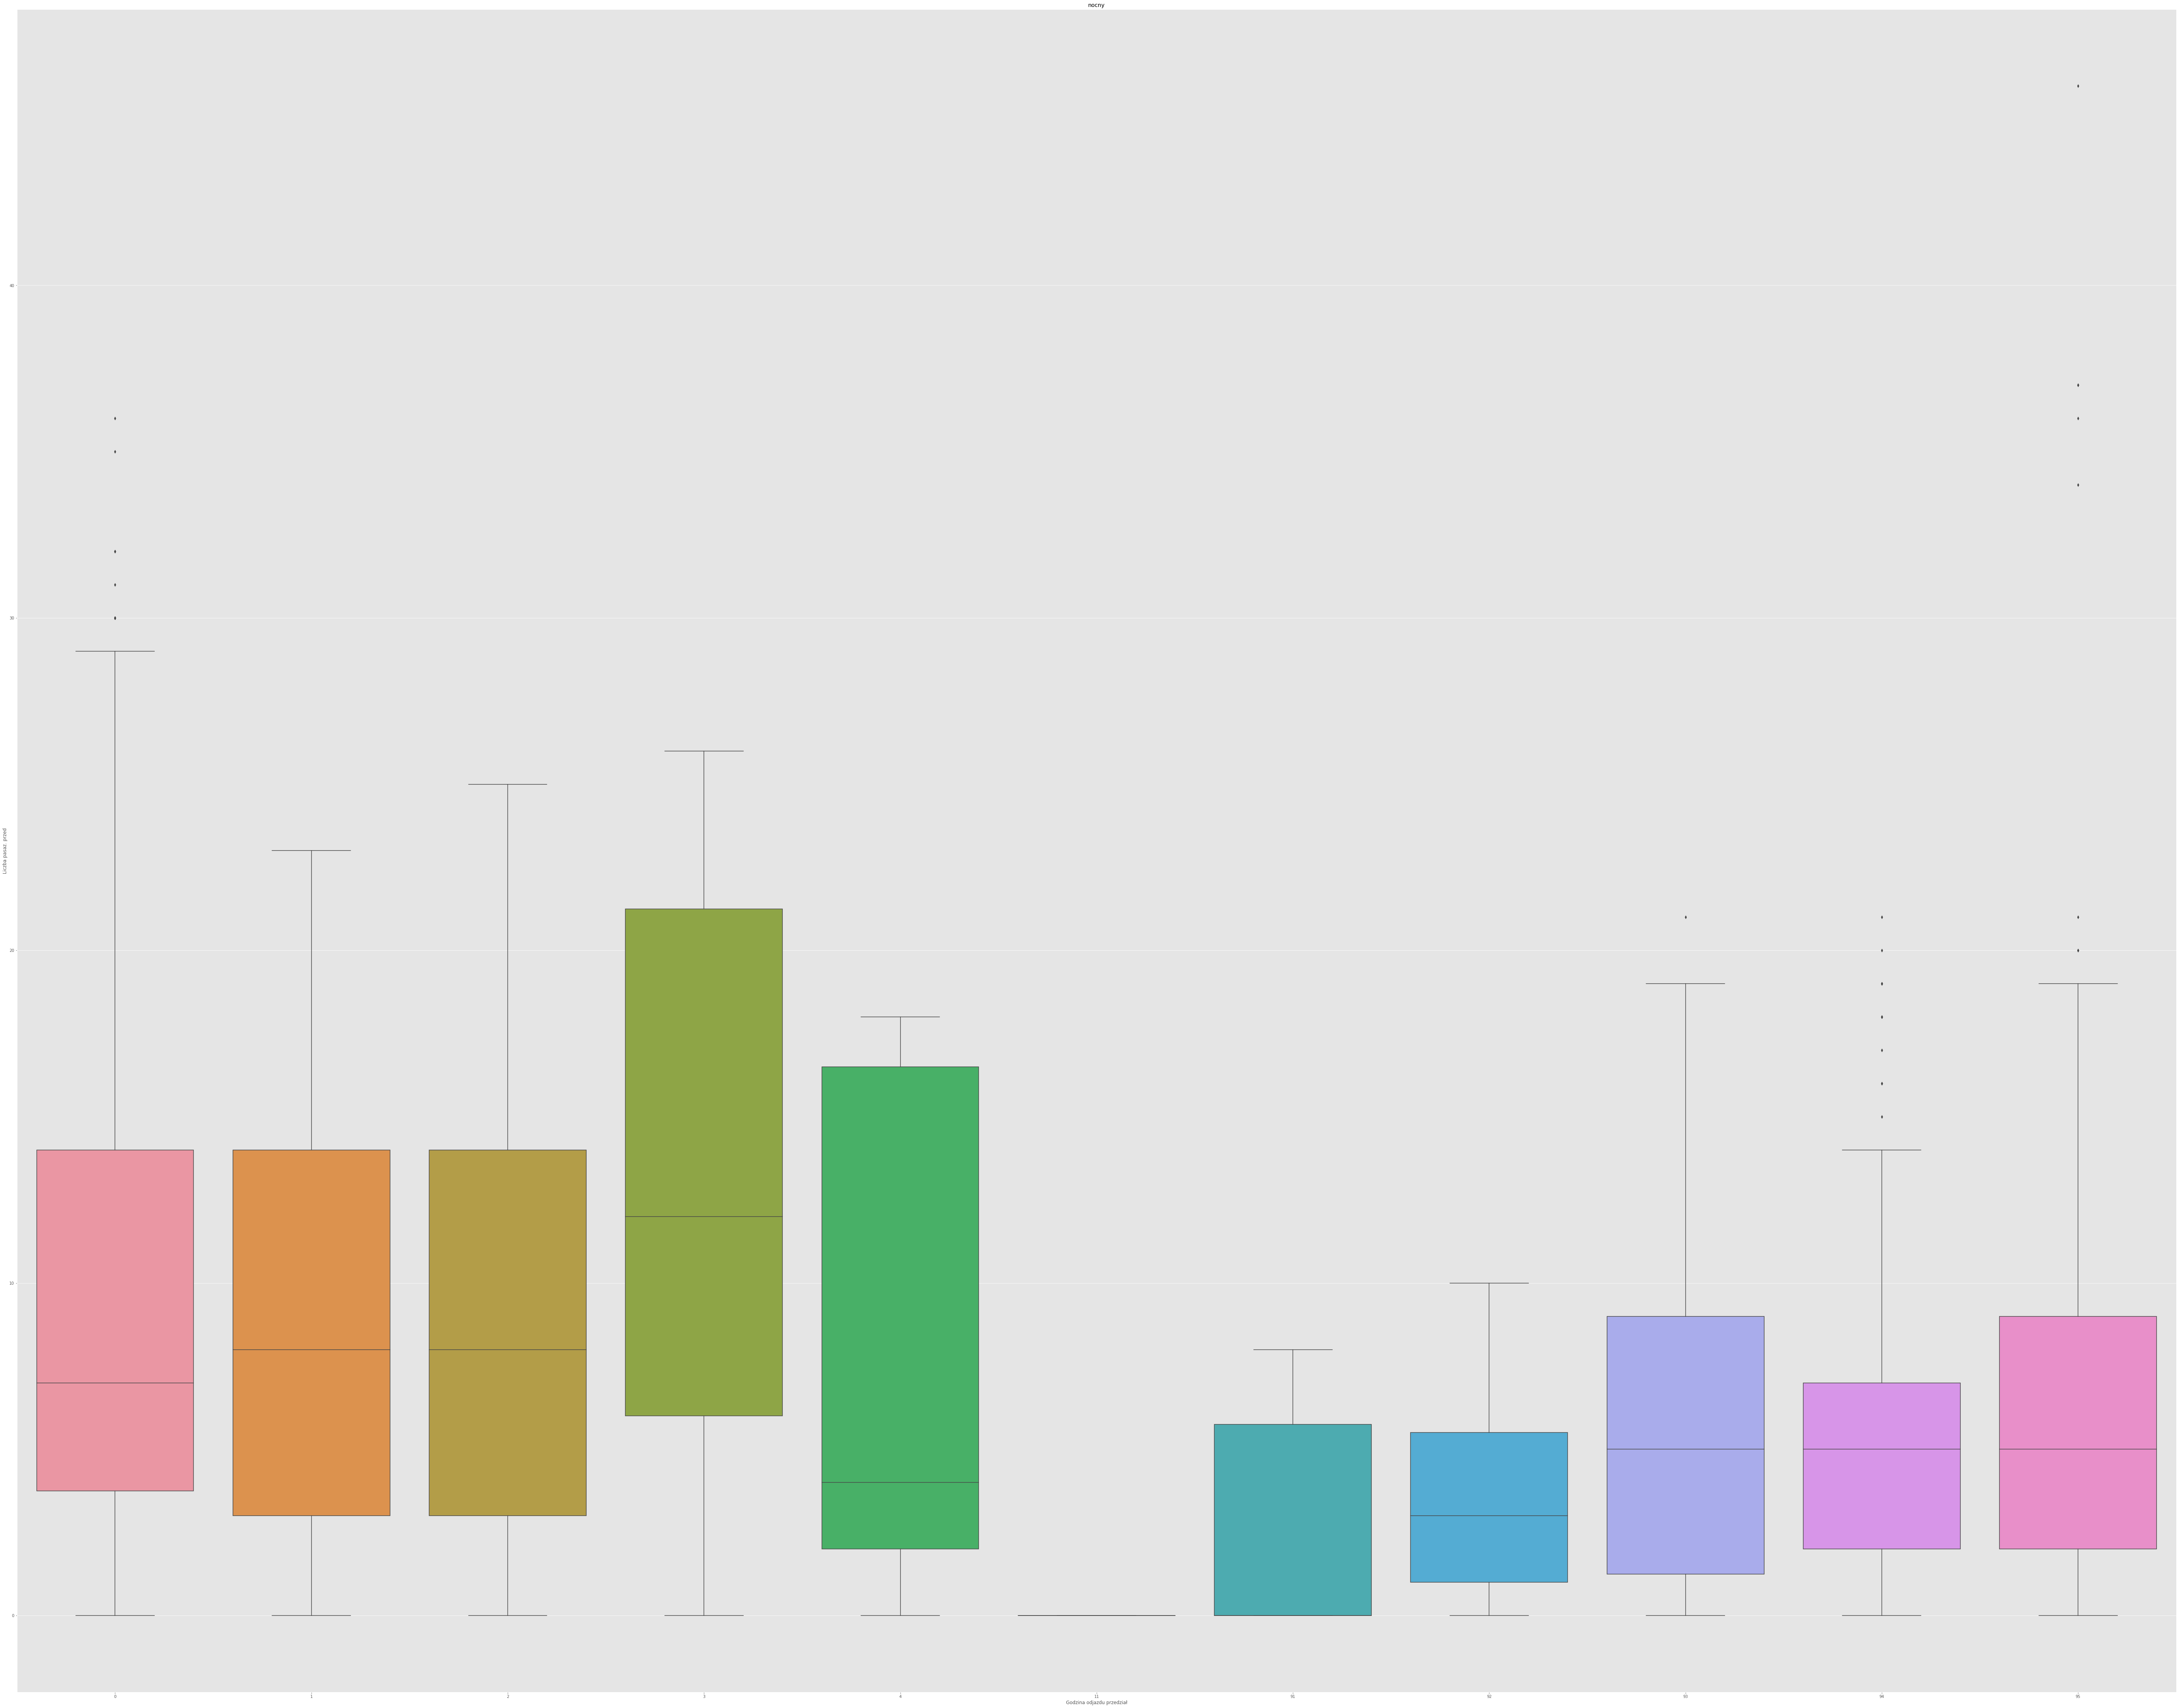

In [7]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y="Liczba pasaz. przed",
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

# 5.1. Porównanie wybranych lini do globalnego podejscia

In [8]:
df_no_type = drop_other_types(df)
df_no_type.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Opóźnienie w minutach
130399,314,TP-OLE,2022-02-01 20:18:00,4,9082,Porajów,2,2022-02-01 20:20:00,2022-02-01 20:21:00,2,0,0,2,20.350000,81,-1
116067,220,TP-OKE,2022-02-01 19:29:00,4,9540,Nowe Bemowo,2,2022-02-01 19:30:00,2022-02-01 19:30:00,2,0,3,5,19.500000,78,0
91168,201,TP-ZNA-S,2022-02-01 13:55:00,2,9215,Metro Księcia Janusza,5,2022-02-01 14:13:00,2022-02-01 14:15:00,28,20,1,9,14.250000,57,-2
36488,149,TP-KOL,2022-02-01 12:14:00,5,9537,Arkadyjska,1,2022-02-01 12:15:00,2022-02-01 12:15:00,6,0,5,11,12.250000,49,0
11250,118,TP-BRP,2022-02-01 09:48:00,6,9679,Podzamcze,2,2022-02-01 10:06:00,2022-02-01 10:06:58,3,0,0,3,10.116111,40,-1


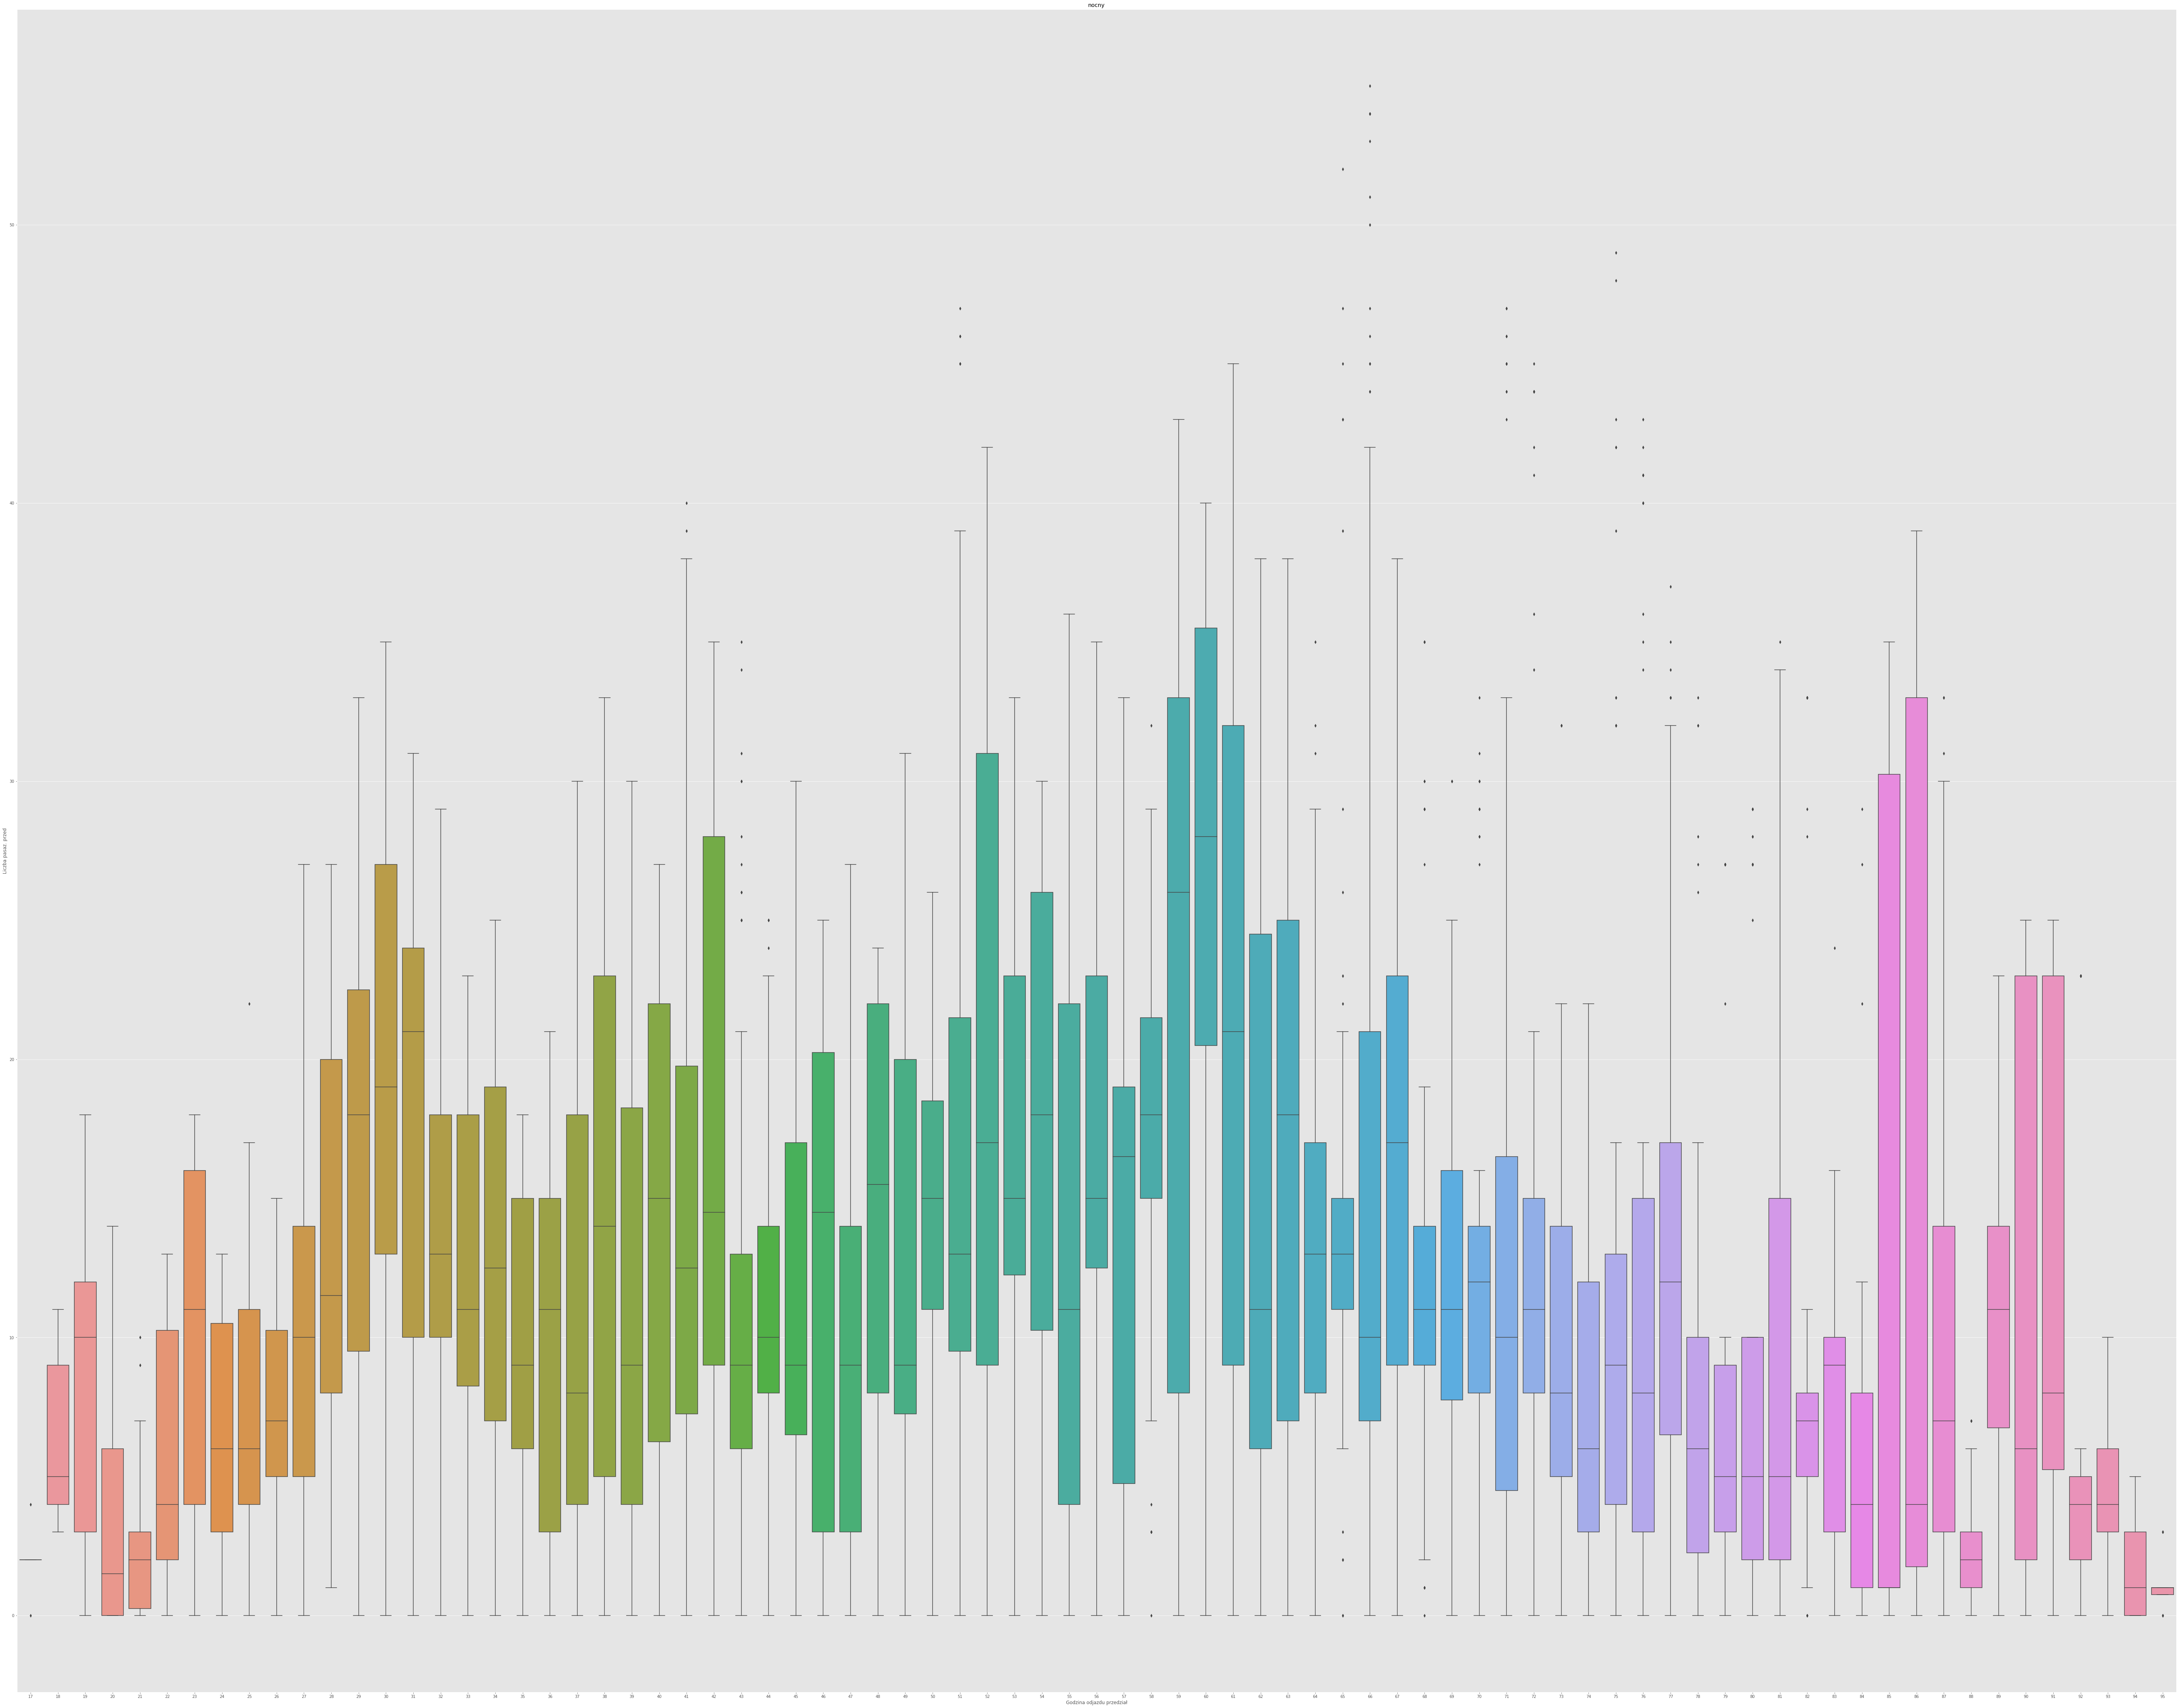

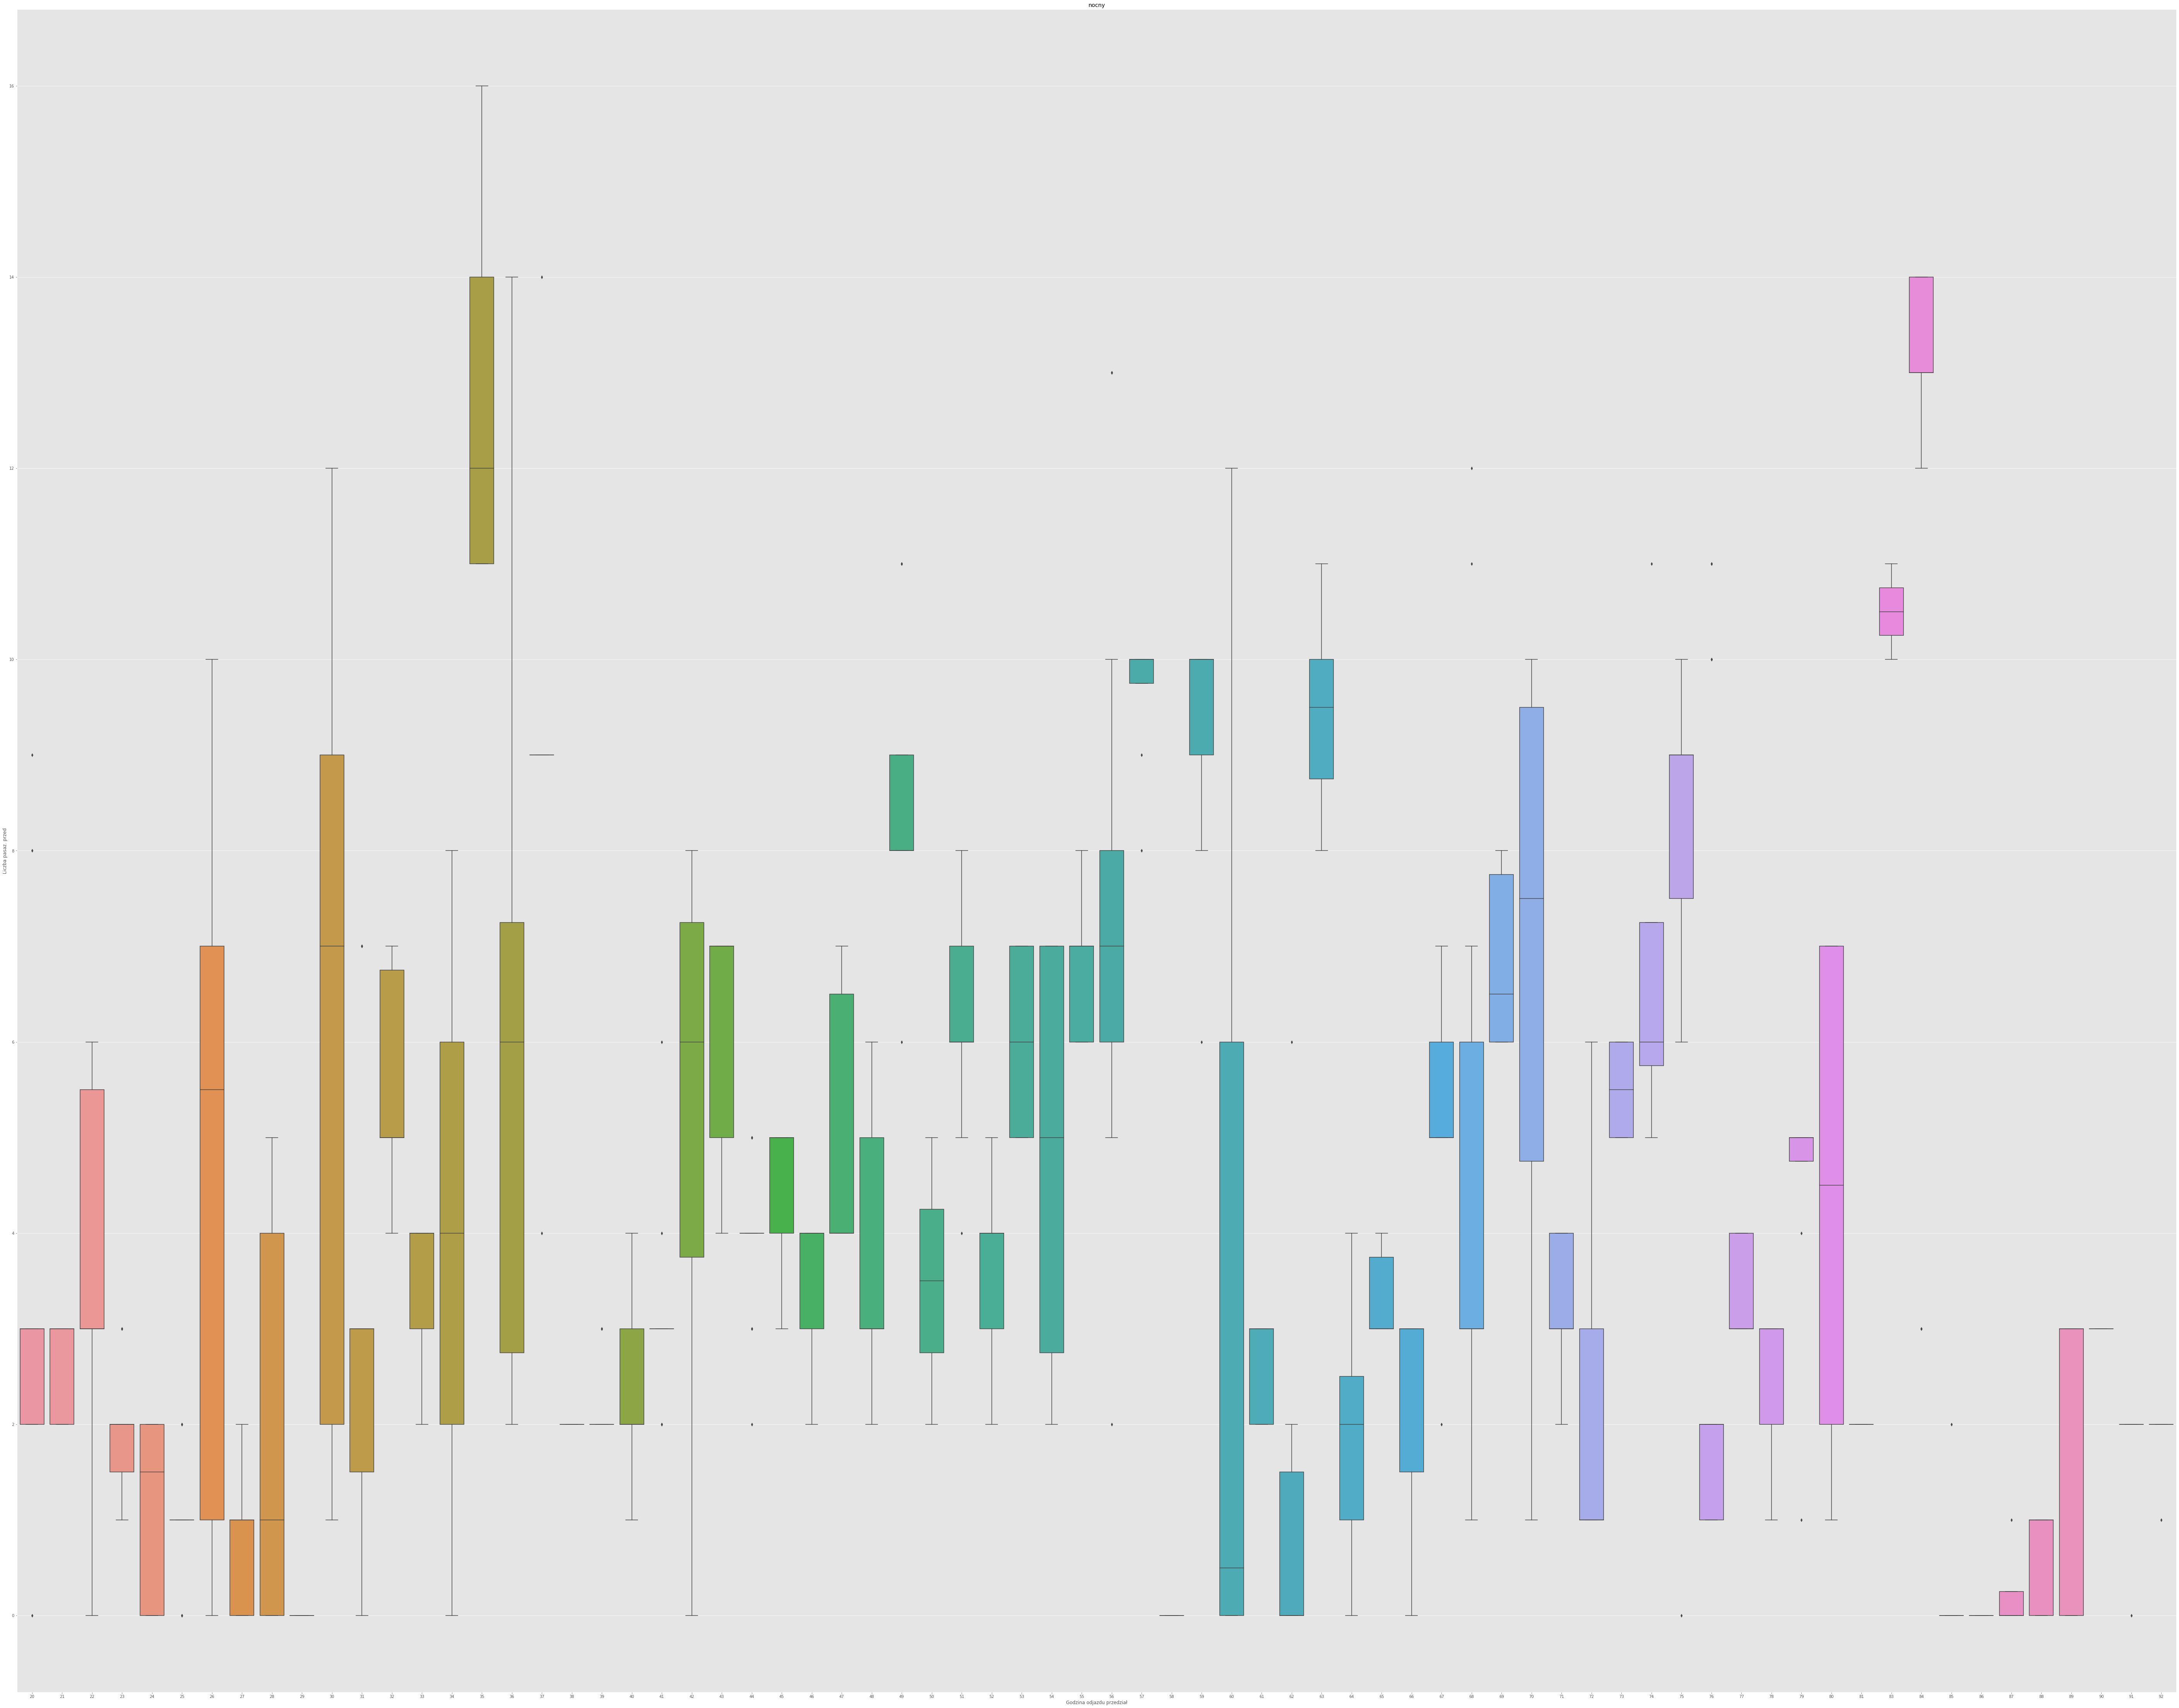

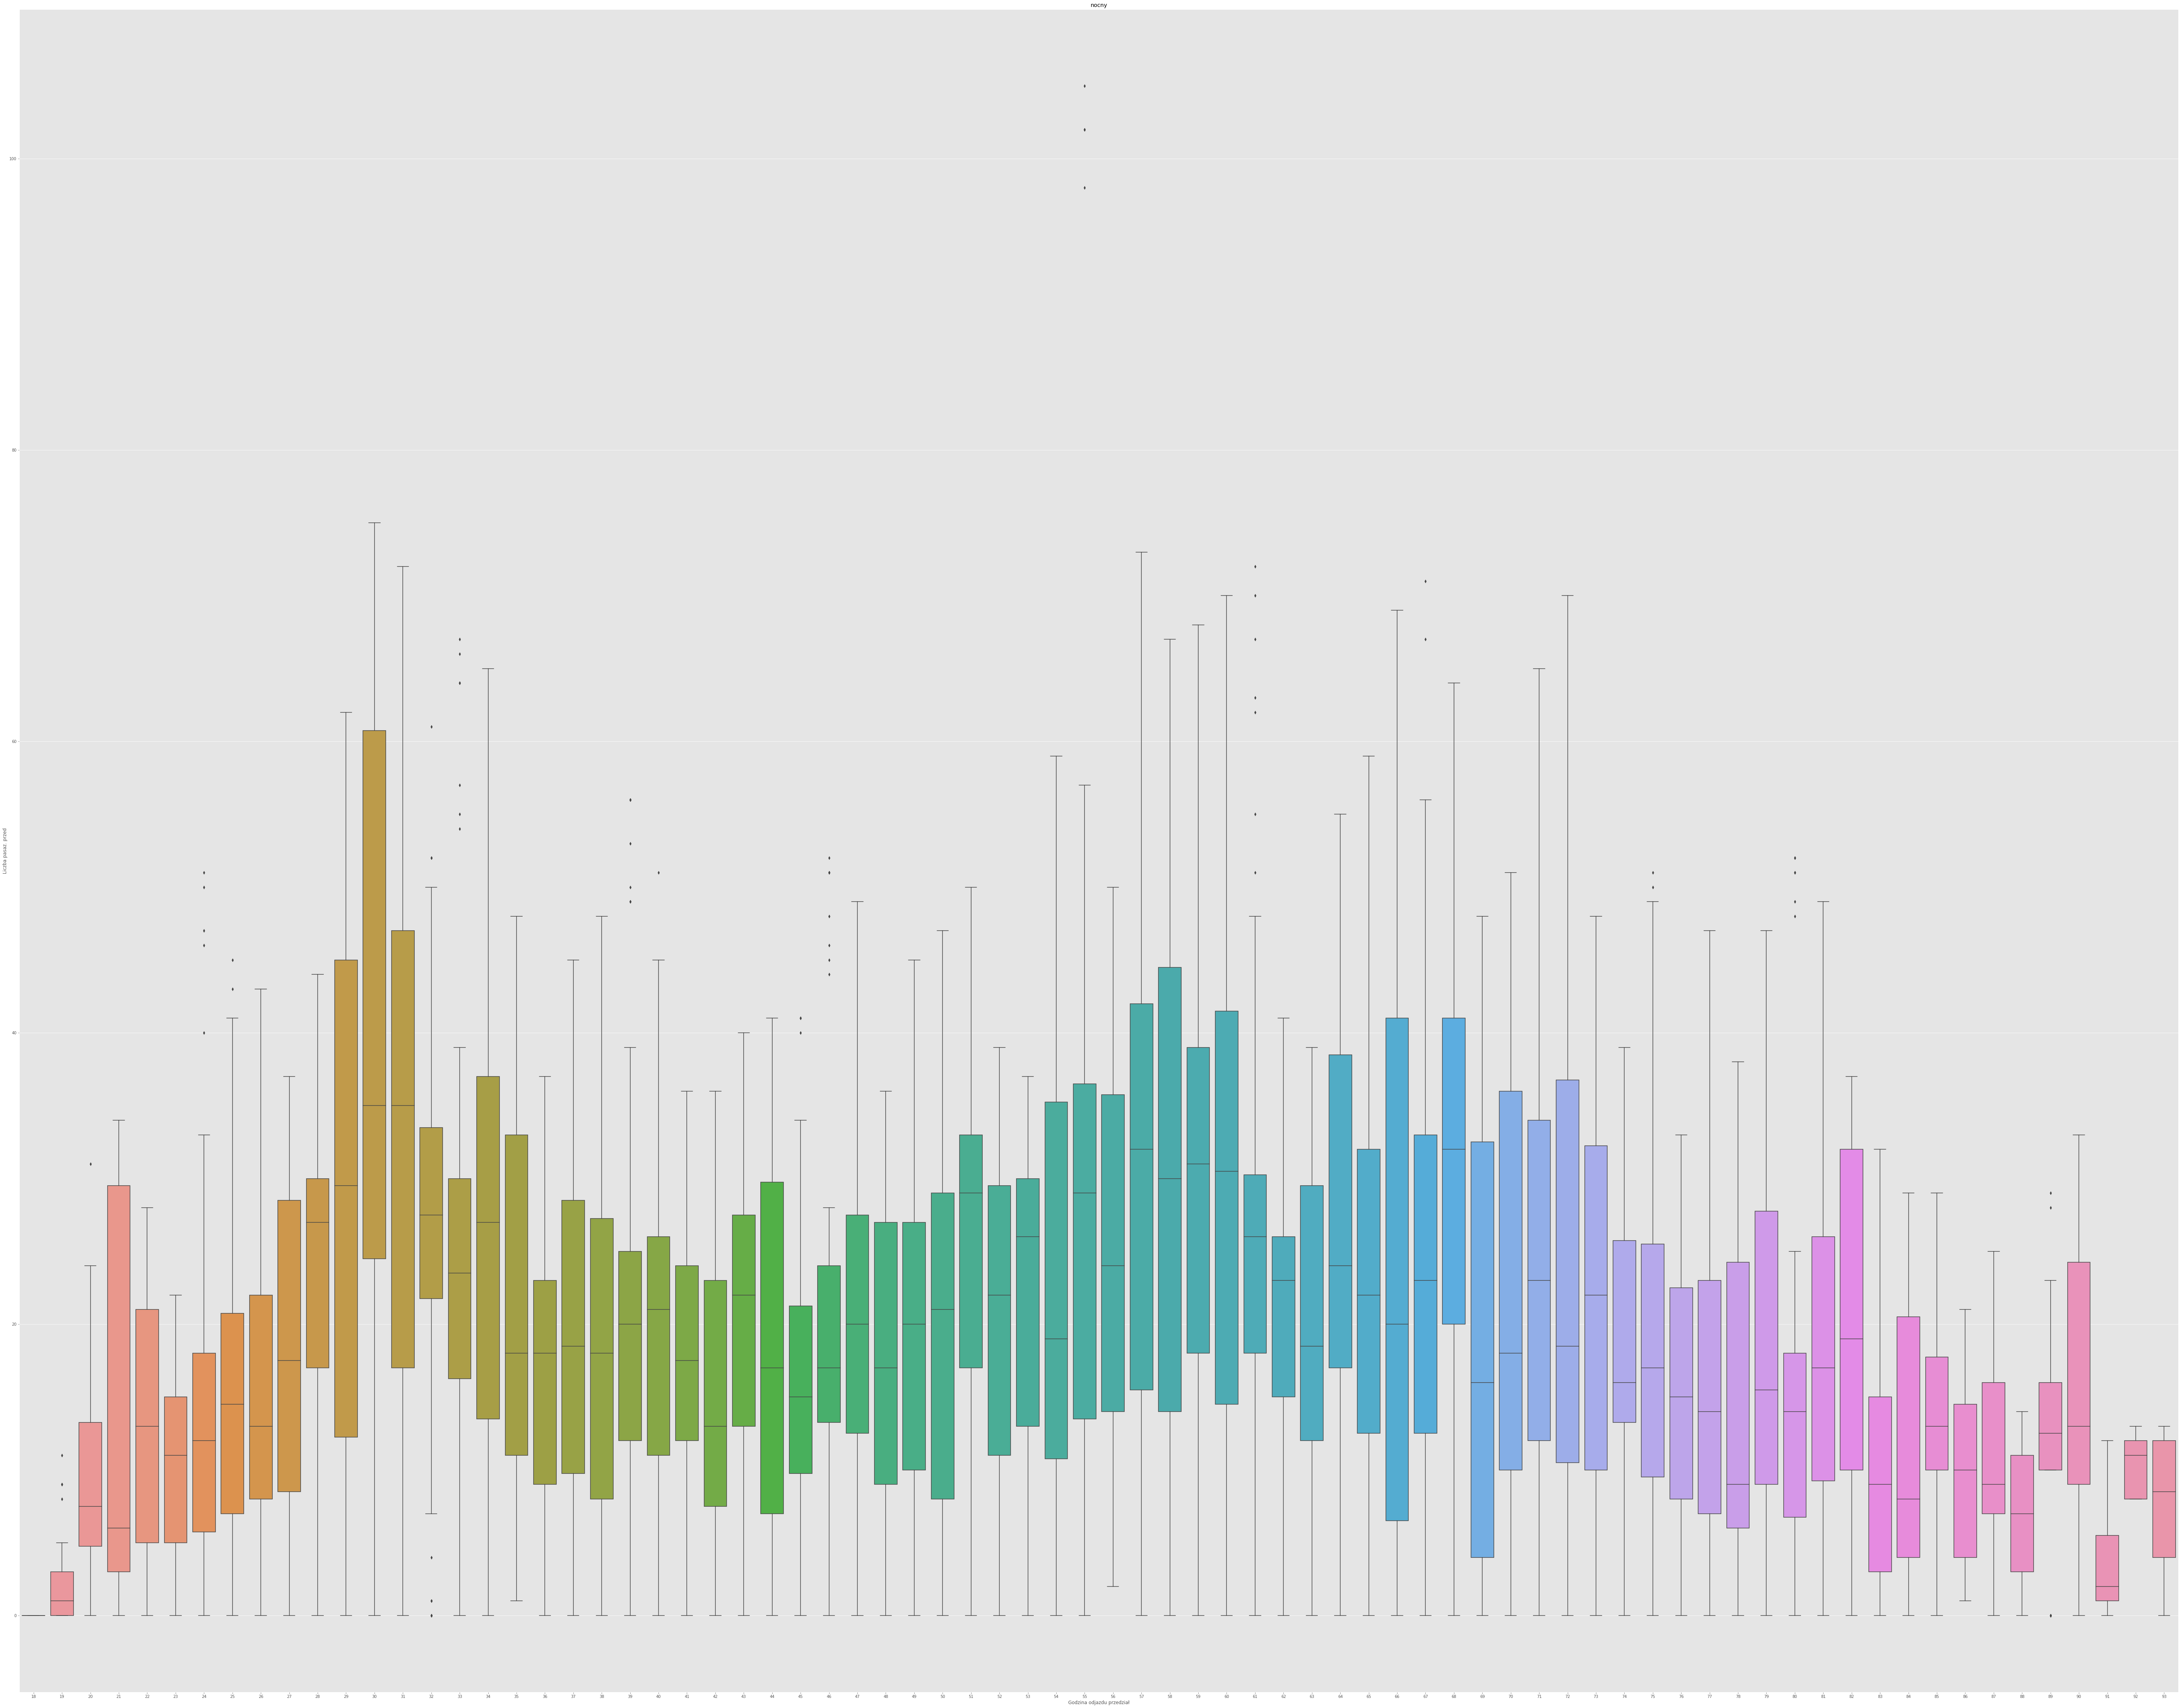

In [9]:
for line_number in ['142', '264', '525']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y="Liczba pasaz. przed",
        data=df_no_type.loc[df['Nr linii']==line_number]
    )
    ax.set_title(trans_type)

# 6. Clustering

In [10]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [11]:
crowding = ["małe zatł.", "średnie zatł.", "duże zatł."]
iterations = 10

df = find_clusters(crowding, iterations, df, "Liczba pasaz. przed")

<Figure size 720x576 with 0 Axes>

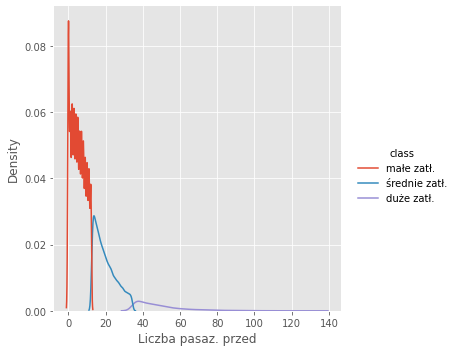

In [12]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x="Liczba pasaz. przed",
    hue='class',
    kind='kde'
)

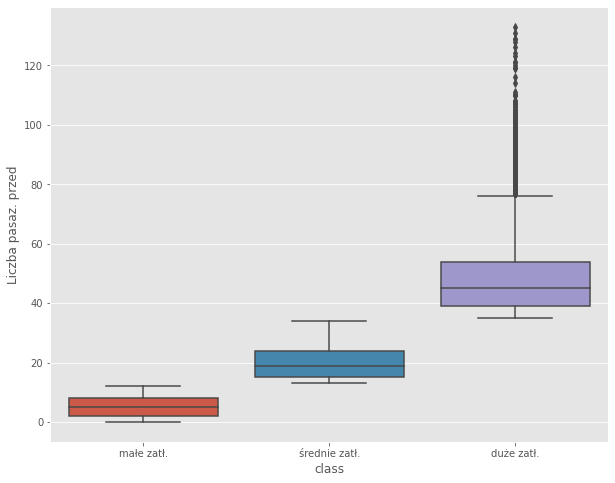

In [13]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=crowding,
    y="Liczba pasaz. przed",
    data=df
)

In [14]:
def create_heatmap(df, corr):
    

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
dfheatmap = df["Liczba pasaz. przed"]

In [16]:
corr = df.corr()
corr

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Opóźnienie w minutach
Numer taborowy,1.000000,-0.002003,0.320958,0.124254,0.123192,0.321755,-0.002678,-0.002722,-0.054544
Numer przystanku,-0.002003,1.000000,-0.030895,0.013882,0.024542,-0.028010,-0.000627,-0.000607,0.004631
Liczba pasaz. przed,0.320958,-0.030895,1.000000,0.374577,0.146987,0.944015,-0.049583,-0.049621,-0.060566
Liczba wysiadających pasaz.,0.124254,0.013882,0.374577,1.000000,0.146362,0.160806,-0.035205,-0.035178,-0.038302
Liczba wsiadajacych pasaz.,0.123192,0.024542,0.146987,0.146362,1.000000,0.370362,-0.049363,-0.049336,-0.007968
Liczba pasaz. po odjezdzie,0.321755,-0.028010,0.944015,0.160806,0.370362,1.000000,-0.053566,-0.053604,-0.052998
Godzina odjazdu,-0.002678,-0.000627,-0.049583,-0.035205,-0.049363,-0.053566,1.000000,0.999908,-0.060636
Godzina odjazdu przedział,-0.002722,-0.000607,-0.049621,-0.035178,-0.049336,-0.053604,0.999908,1.000000,-0.060389
Opóźnienie w minutach,-0.054544,0.004631,-0.060566,-0.038302,-0.007968,-0.052998,-0.060636,-0.060389,1.000000


/tmp/ipykernel_20767/78381014.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


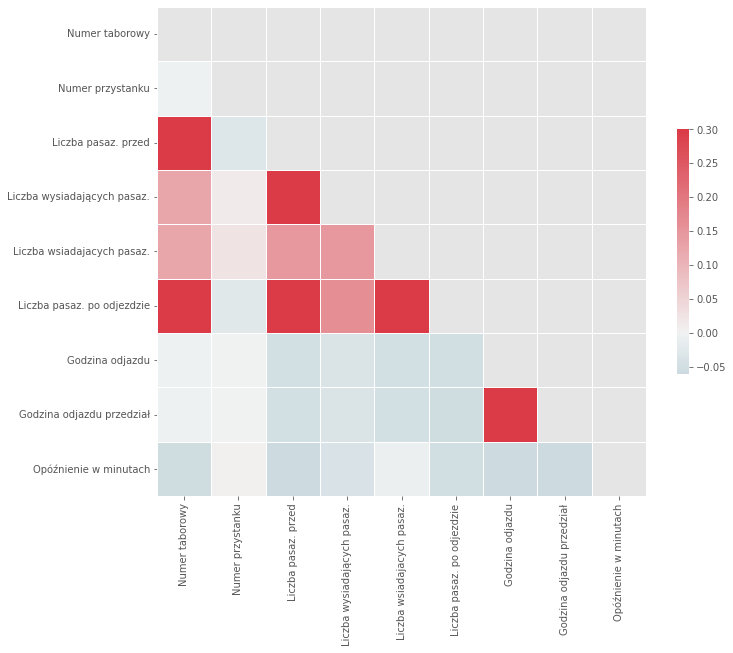

In [17]:
create_heatmap(df,corr)

# 8. Drzewa

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [19]:
def create_tree(features, label, __df, max_depth = 3):
    X_train = __df[features]
    y_train = __df[label]
    
    clf = DecisionTreeClassifier(
        random_state = RANDOM_SEED,
        max_depth = max_depth,
        criterion = 'gini'
    )
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    
    feature_importances = {
        'Feature': features,
        'Importance': clf.feature_importances_
    }
    
    feature_importances_df = pd.DataFrame.from_dict(feature_importances)
    print(feature_importances_df)
    
    cr = classification_report(
        y_train, 
        y_pred, 
        target_names=clf.classes_,
        zero_division=0
    )
    print(cr)
    
    cm = confusion_matrix(
        y_train, 
        y_pred, 
        labels=clf.classes_
    )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=clf.classes_
    )
    disp.plot()
    
    plt.figure(figsize=(80, 60))
    plot_tree(
        clf, 
        filled = True,
        rounded = True,
        label = 'all',
        class_names = clf.classes_
    )
    return clf

In [20]:
df_tree = df_no_type.drop(columns=['Wariant linii','Nazwa przystanku', 'Numer przystanku', 'Rzeczywisty czas odjazdu', 'Rozkładowy czas odjazdu', 'Kurs', 'Oznaczenie brygady'], inplace= False)
df_tree.sample(5)

,Nr linii,Numer taborowy,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Opóźnienie w minutach
112689,219,9201,4,0,0,4,21.900000,87,1
68213,179,9358,6,0,0,6,18.983333,75,-2
66496,179,9328,0,0,0,0,21.566667,86,-2
97328,207,9242,3,0,0,3,19.566667,78,0
76120,186,9930,14,2,2,14,13.500000,54,-3


In [21]:
label = 'class'
features = df_tree.columns[:-1]

tree = create_tree(features, label, df_tree, max_depth=4)

KeyError: 'class'

# 9. PCA